# Exploratory Data Analysis
Exploratory data analysis for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the **early readmission of the patient within 30 days of discharge**.

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [62]:
# Data Analysis
import numpy as np
import pandas as pd
import scipy as sp

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import math

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [63]:
from collections import Counter

from scipy.stats import chi2_contingency, entropy, f_oneway, pointbiserialr, zscore
from scipy.stats.contingency import association

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OrdinalEncoder

### 0.2 Constants

In [64]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

RANDOM_STATE = 38

### 0.3 Loading datasets

In [65]:
diabetic_data = pd.read_csv(
    DATA_PATH + 'diabetic_data.csv',
    na_values='?',
    keep_default_na=False
)

/tmp/ipykernel_5943/651324338.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetic_data = pd.read_csv(


## **1. Data Understanding**
Exploring the dataset structure from afar.

### 1.1 Dataset structure
Having an overall look at the structure of the dataset.

In [66]:
diabetic_data.sample(5)

encounter_id  patient_nbr             race  gender      age weight  \
46260     142864992     37861290            Asian    Male  [50-60)    NaN   
37420     115973406     24722046  AfricanAmerican    Male  [60-70)    NaN   
53635     157137198     94047408        Caucasian  Female  [40-50)    NaN   
69604     198130704     30942189        Caucasian  Female  [50-60)    NaN   
42413     130798236     36967347            Other    Male  [70-80)    NaN   

       admission_type_id  discharge_disposition_id  admission_source_id  \
46260                  1                         2                    7   
37420                  1                         3                    7   
53635                  1                         1                    1   
69604                  2                         1                    7   
42413                  2                         1                    7   

       time_in_hospital payer_code medical_specialty  num_lab_procedures  \
46260                 4         OG  Emergency/Trauma                   8   
37420                 6         MC        Nephrology                  43   
53635                 3         CP               NaN                  47   
69604                 4         UN  Emergency/Trauma                  63   
42413                 5         MD  Emergency/Trauma                   1   

       num_procedures  num_medications  number_outpatient  number_emergency  \
46260               1                7                  0                 0   
37420               2               18                  0                 2   
53635               5               14                  0                 0   
69604               3               16                  0                 1   
42413               1                5                  0                 0   

       number_inpatient  diag_1 diag_2 diag_3  number_diagnoses max_glu_serum  \
46260                 0     424    428    425                 4          None   
37420                 1     996    403    790                 8          None   
53635                 1     410    414    250                 9          None   
69604                 3     428    455    593                 9          None   
42413                 0  250.82    780    272                 4          None   

      A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
46260      None        No          No          No             No          No   
37420      None        No          No          No             No          No   
53635      None        No          No          No             No      Steady   
69604      None    Steady          No          No             No          No   
42413      None    Steady          No          No             No      Steady   

      acetohexamide glipizide glyburide tolbutamide pioglitazone  \
46260            No    Steady        No          No           No   
37420            No        No        No          No           No   
53635            No        No        No          No           No   
69604            No        No        No          No           No   
42413            No        No        No          No           No   

      rosiglitazone acarbose miglitol troglitazone tolazamide examide  \
46260            No       No       No           No         No      No   
37420            No       No       No           No         No      No   
53635            No       No       No           No         No      No   
69604            No       No       No           No         No      No   
42413            No       No       No           No         No      No   

      citoglipton insulin glyburide-metformin glipizide-metformin  \
46260          No      No                  No                  No   
37420          No      Up                  No                  No   
53635          No      No                  No                  No   
69604          No  Steady                  No                  No   


**Feature data types**
- Most features are <u>categorical</u>: demographic, patient characteristics, test results, and medications.
- Some features are <u>numerical</u>: hospital administration related (codes), and patient history related.

In [67]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

**Missing values**
- Weight and payer_code are missing respectively 97% and 40% of values, these can simply be thrown out.
- Medical specialty is also missing 50% of values, but it might be important, and there's a change they can be imputed.
- Very few values for diagnoses and race are missing.

In [68]:
total = diabetic_data.isnull().sum().sort_values(ascending=False)
percent = (diabetic_data.isnull().sum() / diabetic_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

Total   Percent
weight             98569  0.968585
medical_specialty  49949  0.490822
payer_code         40256  0.395574
race                2273  0.022336
diag_3              1423  0.013983
diag_2               358  0.003518
diag_1                21  0.000206
admission_type_id      0  0.000000
patient_nbr            0  0.000000
encounter_id           0  0.000000

### 1.2 Feature Distribution
Having an overall look at the distribution of features.

**Distribution of numerical features**
- The encounter and patient identifiers are not useful, will simply be removed.
- The {something}_id features are not actually numerical, but categorical. Those need to be converted to their string representation.
- Almost all other numerical features present outliers way beyond 3-4 Z-scores. 

In [69]:
diabetic_data.describe()

encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.000000          4.000000   
75%                    4.000000             7.000000          6.000000   
max                   28.000000            25.000000         14.000000   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count       101766.000000   101766.000000    101766.000000      101766.000000   
mean            43.095641        1.339730        16.021844           0.369357   
std             19.674362        1.705807         8.127566           1.267265   
min              1.000000        0.000000         1.000000           0.000000   
25%             31.000000        0.000000        10.000000           0.000000   
50%             44.000000        1.000000        15.000000           0.000000   
75%             57.000000        2.000000        20.000000           0.000000   
max            132.000000        6.000000        81.000000          42.000000   

       number_emergency  number_inpatient  number_diagnoses  
count     101766.000000     101766.000000     101766.000000  
mean           0.197836          0.635566          7.422607  
std            0.930472          1.262863          1.933600  
min            0.000000          0.000000          1.000000  
25%            0.000000          0.000000          6.000000  
50%            0.000000          0.000000          8.000000  
75%            0.000000          1.000000          9.000000  
max           76.000000         21.000000         16.000000

**Distribution of categorical features**
- Many features (race, gender, age...) have less than 10 values, they can mostly be left as is.
- A few values (change, diabetesMed) are binary, which makes them very easy to handle.
- Some features (medical_specialty, diagnoses) are a huge amount of values, they will require binning somehow.

In [70]:
diabetic_data.describe(include=['O'])

race  gender      age    weight payer_code medical_specialty  \
count       99493  101766   101766      3197      61510             51817   
unique          5       3       10         9         17                72   
top     Caucasian  Female  [70-80)  [75-100)         MC  InternalMedicine   
freq        76099   54708    26068      1336      32439             14635   

        diag_1  diag_2  diag_3 max_glu_serum A1Cresult metformin repaglinide  \
count   101745  101408  100343        101766    101766    101766      101766   
unique     716     748     789             4         4         4           4   
top        428     276     250          None      None        No          No   
freq      6862    6752   11555         96420     84748     81778      100227   

       nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
count       101766         101766      101766        101766    101766   
unique           4              4           4             2         4   
top             No             No          No            No        No   
freq        101063         101680       96575        101765     89080   

       glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
count     101766      101766       101766        101766   101766   101766   
unique         4           2            4             4        4        4   
top           No          No           No            No       No       No   
freq       91116      101743        94438         95401   101458   101728   

       troglitazone tolazamide examide citoglipton insulin  \
count        101766     101766  101766      101766  101766   
unique            2          3       1           1       4   
top              No         No      No          No      No   
freq         101763     101727  101766      101766   47383   

       glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
count               101766              101766                   101766   
unique                   4                   2                        2   
top                     No                  No                       No   
freq                101060              101753                   101765   

       metformin-rosiglitazone metformin-pioglitazone  change diabetesMed  \
count                   101766                 101766  101766      101766   
unique                       2                      2       2           2   
top                         No                     No      No         Yes   
freq                    101764                 101765   54755       78363   

       readmitted  
count      101766  
unique          3  
top            NO  
freq        54864

## **2. Data Visualization (pre)**
Having an initial look at the relationships between features, before preprocessing.

### 2.0 Functions
General-purpose functions for visual analysis.

#### 2.0.1 Correlation/association measures

In [71]:
def phi_values(data: pd.DataFrame, binary_cols: list[str]):
    pb = pd.DataFrame(index=binary_cols, columns=binary_cols)
    
    for bin_col_1 in binary_cols:
        for bin_col_2 in binary_cols:    
            contingency_table = pd.crosstab(data[bin_col_2], data[bin_col_1])
            
            # Extract values
            A = contingency_table.iloc[0, 0]
            B = contingency_table.iloc[0, 1]
            C = contingency_table.iloc[1, 0]
            D = contingency_table.iloc[1, 1]

            # Phi Coefficient
            numerator = (A * D) - (B * C)
            denominator = np.sqrt((A + B) * (C + D) * (A + C) * (B + D))
            phi = numerator / denominator
            
            pb.loc[bin_col_2, bin_col_1] = phi
    
    return pb.astype(float)

In [72]:
def point_biserial_values(data: pd.DataFrame, binary_cols: list[str], numerical_cols: list[str]):
    pb = pd.DataFrame(index=binary_cols, columns=numerical_cols)
    
    for num_col in numerical_cols:
        for binary_col in binary_cols:
            tmp = data[[binary_col, num_col]].dropna(axis=0)
            
            corr, _ = pointbiserialr(
                x=tmp[binary_col].astype(float),
                y=tmp[num_col]
            )
            pb.loc[binary_col, num_col] = corr
    
    return pb.astype(float)

In [73]:
def anova_values(data: pd.DataFrame, categorical_cols: list[str], numerical_cols: list[str]):
    anova = pd.DataFrame(index=categorical_cols, columns=numerical_cols)

    for num_col in numerical_cols:
        for cat_col in categorical_cols:
            # Get the unique category values
            categories = data[cat_col].unique()
            
            # Group the numerical values by the categories
            groups = [data[data[cat_col] == category][num_col] for category in categories]
            
            # Perform ANOVA
            f_val, _ = f_oneway(*groups)
            
            # Store the results
            anova.loc[cat_col, num_col] = f_val
    
    return anova.astype(float)

In [74]:
def cramer_values(data: pd.DataFrame, columns: list[str]):
    cramer_v = pd.DataFrame(index=columns, columns=columns)

    for col1 in columns:
        for col2 in columns:
            contingency_table = pd.crosstab(data[col1], data[col2])
            stat = association(contingency_table, method='cramer')
            cramer_v.loc[col1, col2] = stat
    
    return cramer_v.astype(float)

In [75]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


def theil_values(data: pd.DataFrame, columns: list[str]):
    theil = pd.DataFrame(index=columns, columns=columns)

    for col1 in columns:
        for col2 in columns:
            stat = theil_u(
                x=data[col1],
                y=data[col2]
            )
            theil.loc[col1, col2] = stat
    
    return theil.astype(float)

#### 2.0.2 Graphs

In [76]:
def heatmap_crosstab(
        data: pd.DataFrame,
        x: str, y: str,
        rows: pd.Index | None = None,
        columns: pd.Index | None = None
):
    """
    Counts occurrences of each combination of categories between two variables,
    then visualize it using a heatmap.
    """
    # Create the crosstab with the specific column order
    crosstab = pd.crosstab(data[y], data[x])
    crosstab = crosstab.reindex(index=rows, columns=columns)

    # Normalize the crosstab to get column-wise percentages
    crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

    # Create an annotation matrix combining counts and percentages
    annotations = np.empty(crosstab.shape, dtype=object)
    for i in range(crosstab.shape[0]):
        for j in range(crosstab.shape[1]):
            count = crosstab.iloc[i, j]
            percent = crosstab_percent.iloc[i, j]

            if pd.isna(count) or pd.isna(percent):
                annotations[i, j] = 'N/A'
            else:
                annotations[i, j] = f'{count}\n({percent:.2f}%)' 

    # Plot the heatmap
    return sns.heatmap(
        crosstab_percent,
        annot=annotations,
        cmap="YlGnBu",
        fmt=''
    )

In [77]:
def phi_matrix(data: pd.DataFrame, binary_cols: list[str], **kwargs):
    pb = phi_values(data, binary_cols)
    
    return sns.heatmap(
        pb,
        annot=True,
        **kwargs
    )


def point_biserial_matrix(data: pd.DataFrame, binary_cols: list[str], numerical_cols: list[str], **kwargs):
    pb = point_biserial_values(data, binary_cols, numerical_cols)
    
    return sns.heatmap(
        pb,
        annot=True,
        **kwargs
    )


def anova_matrix(data: pd.DataFrame, categorical_cols: list[str], numerical_cols: list[str], **kwargs):
    anova = anova_values(data, categorical_cols, numerical_cols)
    
    return sns.heatmap(
        anova,
        annot=True,
        **kwargs
    )


def cramer_matrix(data: pd.DataFrame, columns: list[str], **kwargs):
    cramer_v = cramer_values(data, columns)
    
    return sns.heatmap(
        cramer_v,
        annot=True,
        **kwargs
    )


def theil_matrix(data: pd.DataFrame, columns: list[str], **kwargs):
    theil = theil_values(data, columns)
    
    return sns.heatmap(
        theil,
        annot=True,
        **kwargs
    )

### 2.1 Correlation / Association
Exploring the numeric correlation or association between different features.

In [78]:
NUMERICAL_COLUMNS = [
    'number_inpatient', 'number_outpatient', 'number_emergency',
    'num_medications', 'number_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital'
]

CATEGORICAL_COLUMNS = [
    'readmitted', 'gender', 'age',
    'max_glu_serum', 'A1Cresult',
    'metformin', 'insulin', 'change', 'diabetesMed'
]

#### 2.1.1 Numerical features
- The feature **num_medications** has strong correlation with many other features, especially time spent in hospital and those related to procedures and diagnoses.
- The feature **number_impatient** seems to have a correlation with number_emergency, not particularly strong, but not even weak.

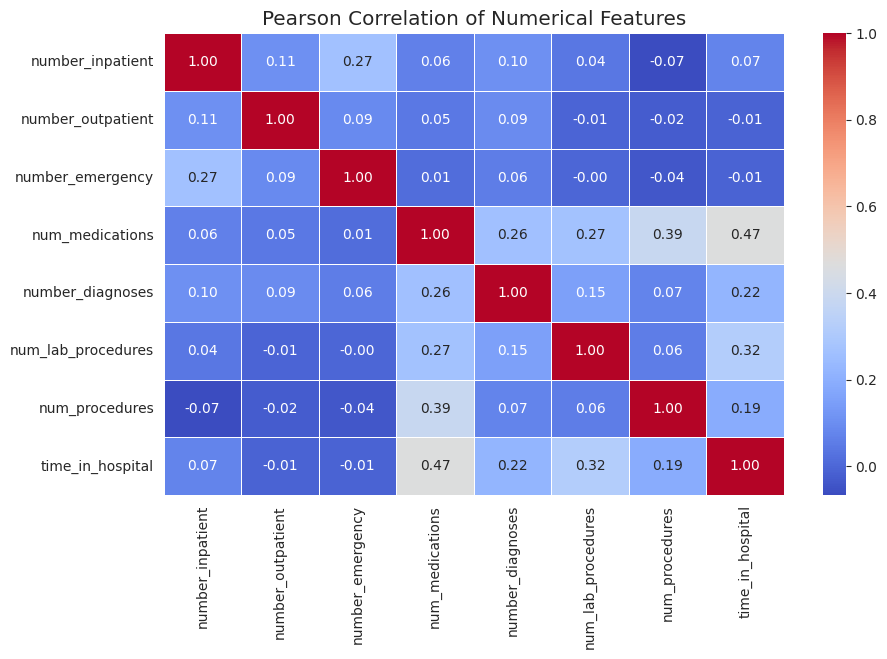

In [79]:
temp_data = diabetic_data[NUMERICAL_COLUMNS]
data_corr = temp_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Pearson Correlation of Numerical Features')
plt.show()

#### 2.1.2 Categorical features
- The feature **readmitted** has incredibly weak correlation with all categorical features... we're not in luck.
- Closer attention should be kept in consideration to **insulin**, since it shows strong correlation with both change and diabetesMed.
- Some medications show slightly higher association (metformin, glipizide, pioglitazione)... with both change and diabetesMed.

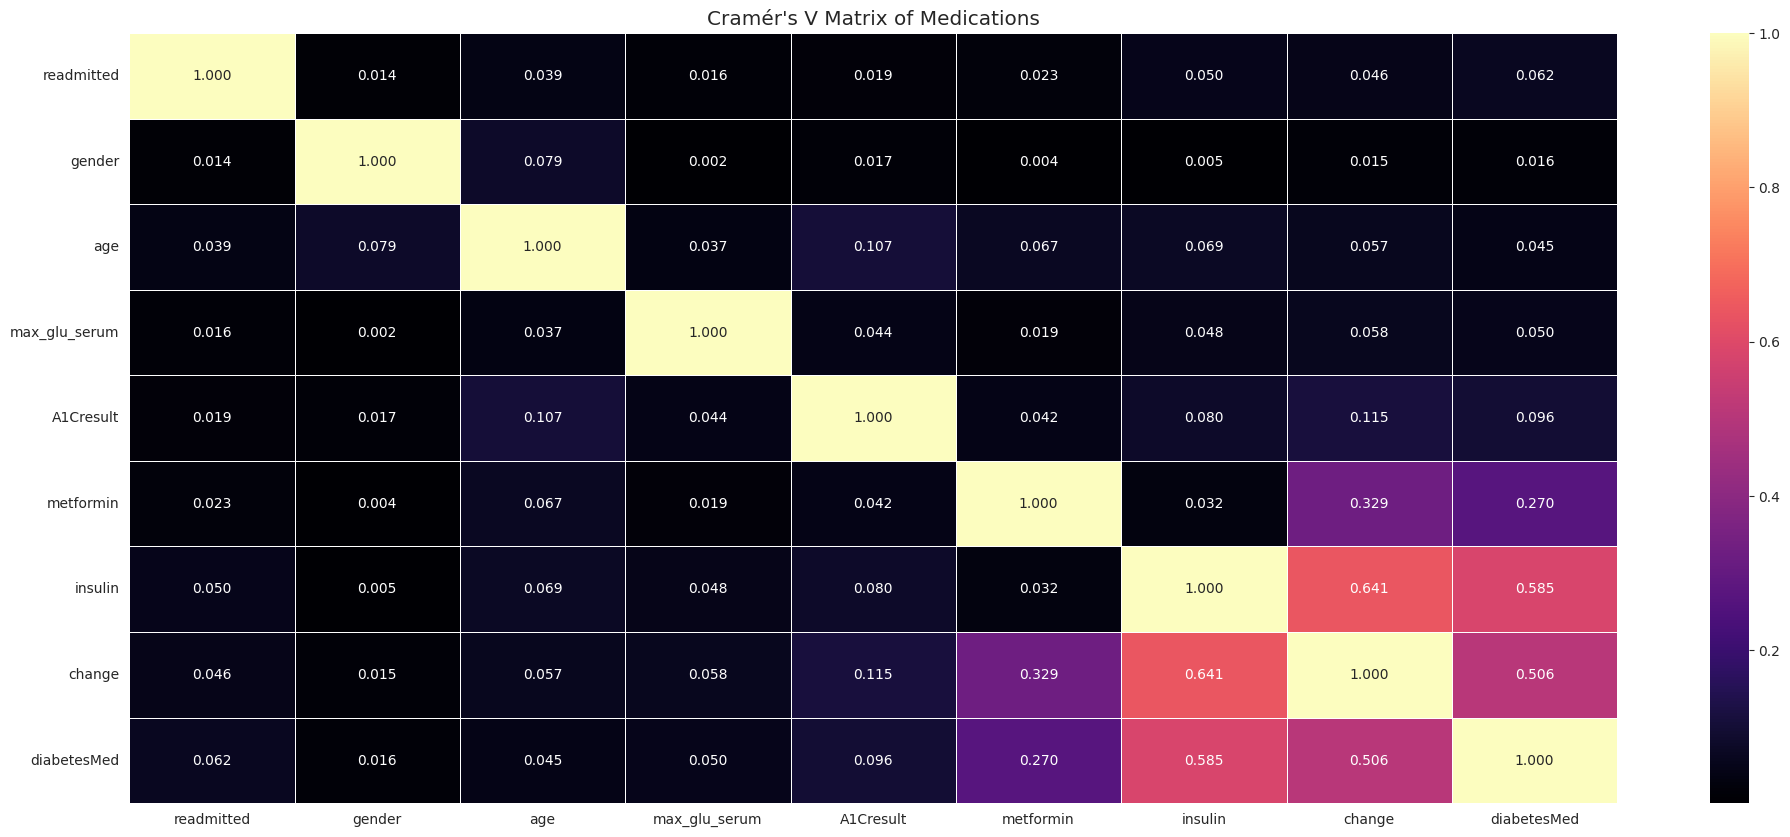

In [80]:
plt.figure(figsize=(24, 10))  # Set the figure size
cramer_matrix(
    data=diabetic_data,
    columns=CATEGORICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'magma', fmt='.3f'
)
plt.title("Cramér's V Matrix of Medications")
plt.show()

#### 2.1.3 Categorical-numerical features
- The feature **number_impatient** seems to have a decent association with number_impatient.
- Other features also show a bit of association with readmission (number_diagnosis, number_emergency), but the associations are noticeably weaker.

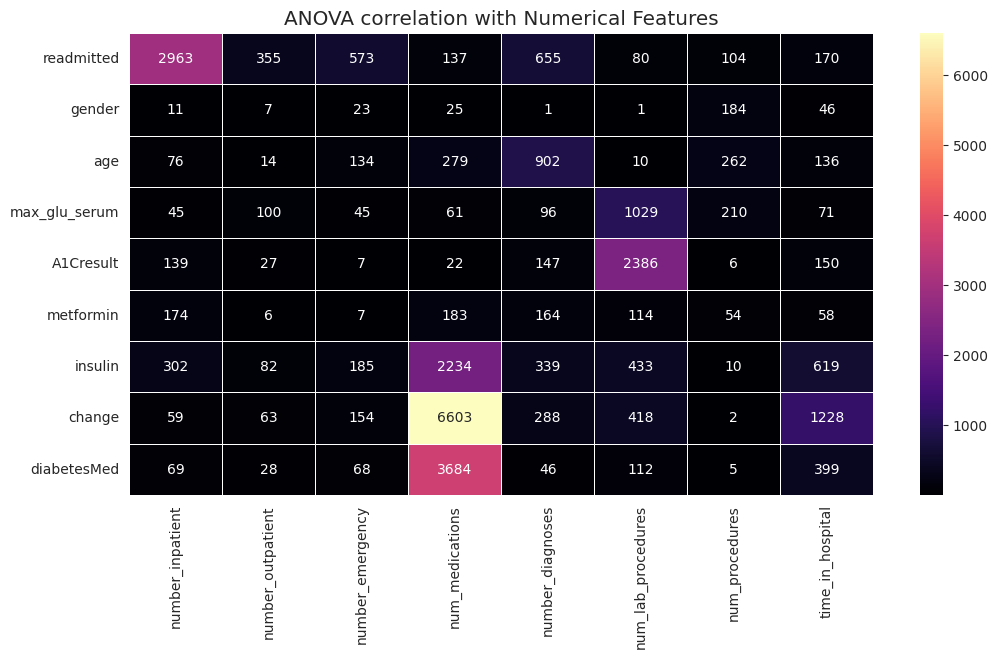

In [81]:
plt.figure(figsize=(12, 6))  # Set the figure size
anova_matrix(
    data=diabetic_data,
    categorical_cols=CATEGORICAL_COLUMNS,
    numerical_cols=NUMERICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'magma', fmt='.0f'
)
plt.title('ANOVA correlation with Numerical Features')
plt.show()

### 2.2 Bivariate Analysis with Readmission
Exploring the relationship of multiple features with readmission status.

#### 2.2.1 Non-medication features

For **A1Cresult**, there doesn't seem to be any direct visible relationship with the readmissions.

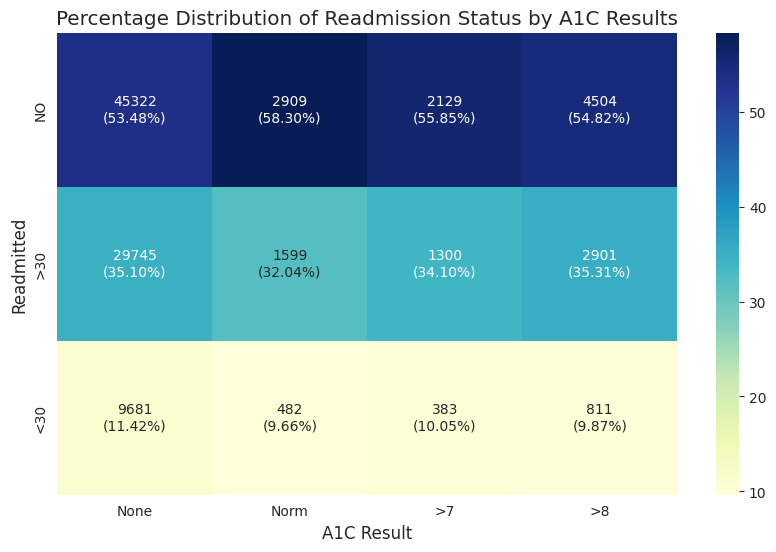

In [82]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='A1Cresult',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['None', 'Norm', '>7', '>8']
)

plt.title('Percentage Distribution of Readmission Status by A1C Results')
plt.xlabel('A1C Result')
plt.ylabel('Readmitted')
plt.show()

For **max_glu_serum**, there is a visible direct correlation with readmission rates. For people that were readmitted within 30 days, but also for those readmitted after 30 days, readmission rates increase with the increase of glucose. For all those people that were not readmitted, there is an inverse relationship with the increase of glucose levels.

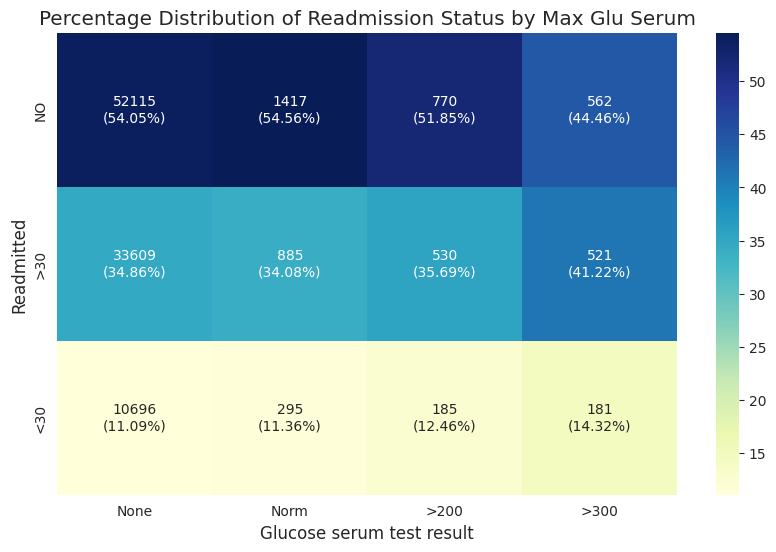

In [83]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='max_glu_serum',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['None', 'Norm', '>200', '>300']
)

plt.title('Percentage Distribution of Readmission Status by Max Glu Serum')
plt.xlabel('Glucose serum test result')
plt.ylabel('Readmitted')
plt.show()

For **age**, there is a very slight correlation with readmission rates. Percentage of readmitted people, both for <30 and >30, is directly proportional up to 20 years. After the 20s, we notice an attenuation of values, meaning that the readmission percentage does not increase as the age increases, but remains stable.

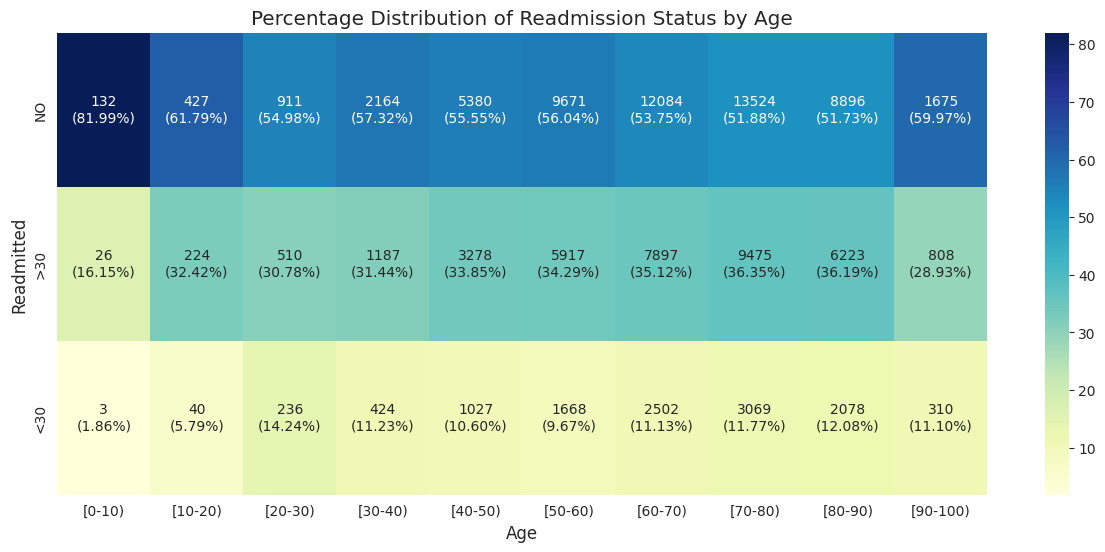

In [84]:
plt.figure(figsize=(15, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='age',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=[
        '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
        '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
    ]
)

plt.title('Percentage Distribution of Readmission Status by Age')
plt.xlabel('Age')
plt.ylabel('Readmitted')
plt.show()

For both **gender** and **race**, there is no visible correlation with readmissions. _Too bad, we can't make racist elmo._ 👀

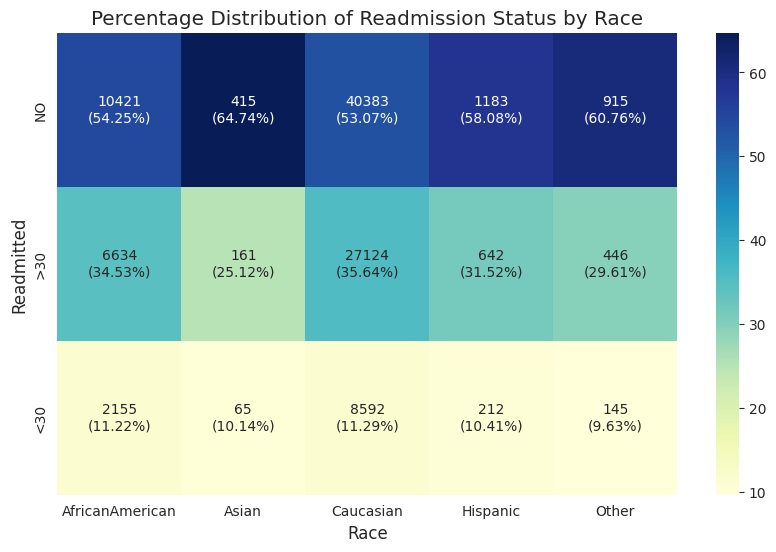

In [85]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='race',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=[0, 1]
)

plt.title('Percentage Distribution of Readmission Status by Race')
plt.xlabel('Race')
plt.ylabel('Readmitted')
plt.show()

For **change**, there is a small correlation with readmissions. A change in medication seems to lead to easier readmission.

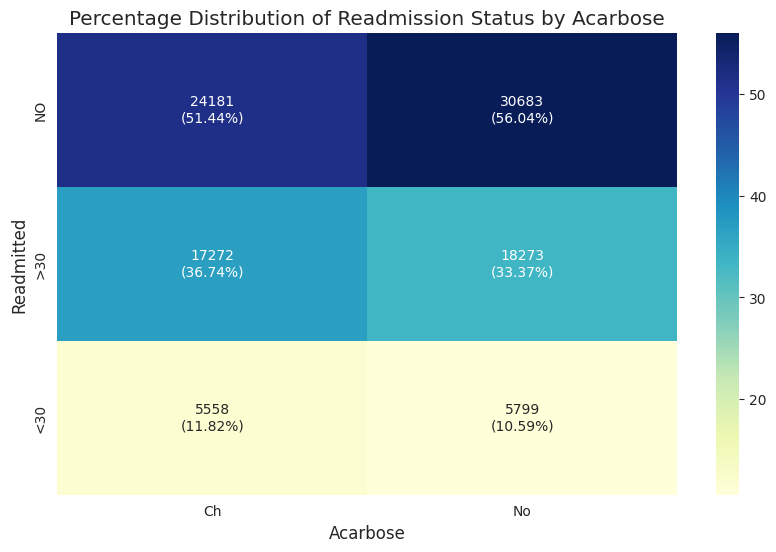

In [86]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='change',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

For **diabetesMed**, there is a small correlation with readmissions. Subministration of diabetes medications seems to lead to easier readmission.

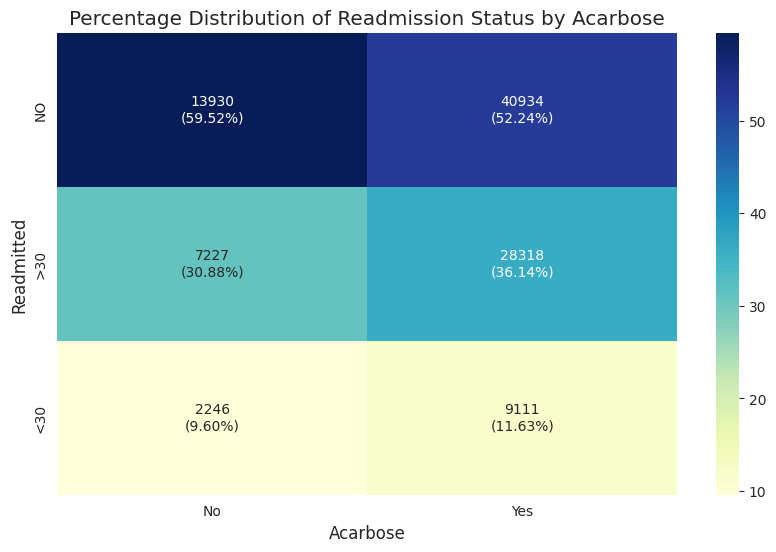

In [87]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diabetesMed',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

#### 2.2.2 Medication features

For **insulin**, if you leave unmodified, everything is fine... if you change the dosage, shit hits the fan.

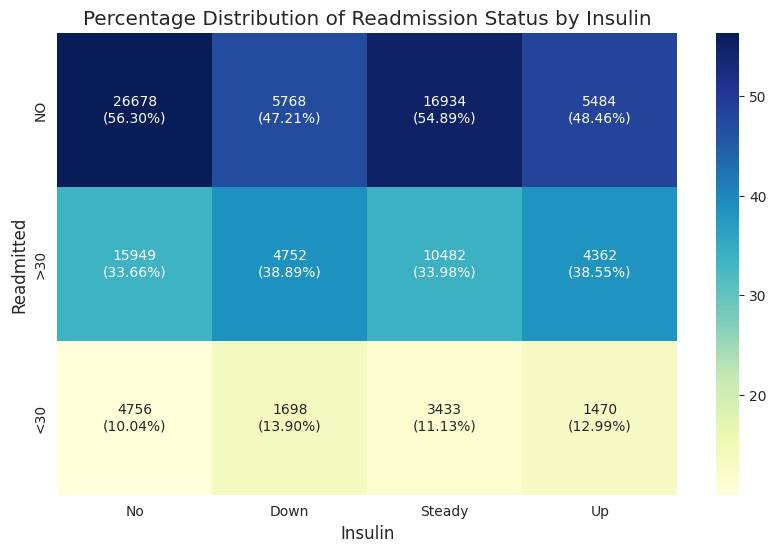

In [88]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='insulin',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)

plt.title('Percentage Distribution of Readmission Status by Insulin')
plt.xlabel('Insulin')
plt.ylabel('Readmitted')
plt.show()

For **metmorfin**, there is no visible correlation whatsover...

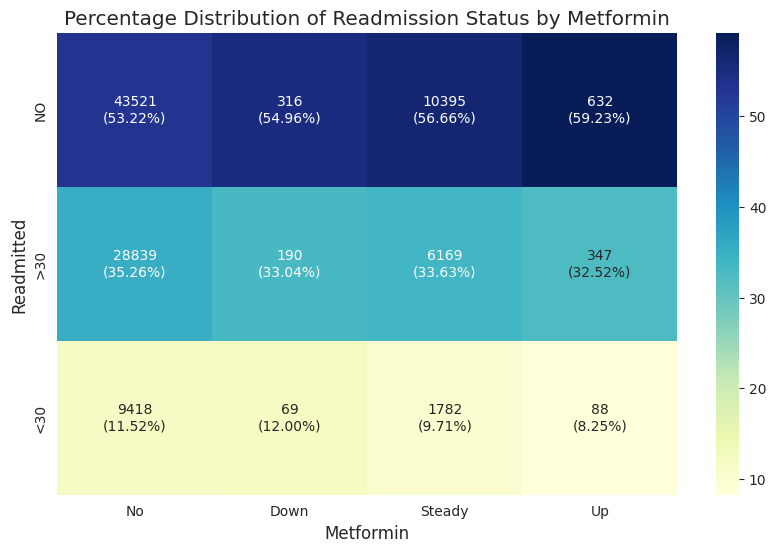

In [89]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='metformin',
    y='readmitted',
    rows=['NO', '>30', '<30'],
    columns=['No', 'Down', 'Steady', 'Up']
)

plt.title('Percentage Distribution of Readmission Status by Metformin')
plt.xlabel('Metformin')
plt.ylabel('Readmitted')
plt.show()

## **3. Preprocessing**
Modifying and casting data, imputing missing values, creating new features, and so on.

### 3.1 Data Pre-Cleaning
Handling duplicate entries, and removing incomplete/unnecessary columns.

#### 3.1.1 Duplicates
Looking for duplicate instances, by excluding the reference to the patient and encounter identifiers. Luckily, there are none of them.

In [90]:
temp_data = diabetic_data.drop(columns=['encounter_id', 'patient_nbr'])
duplicates = temp_data[temp_data.duplicated()]
duplicates

Empty DataFrame
Columns: [race, gender, age, weight, admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, payer_code, medical_specialty, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, diag_1, diag_2, diag_3, number_diagnoses, max_glu_serum, A1Cresult, metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone, change, diabetesMed, readmitted]
Index: []

#### 3.1.2 Pseudo-duplicates

Keep one visit per patient within each age group. This is to make sure that there are no "pseudo-duplicate" instances, in the sense that have very similar traits since they relate to the same patient.

In [91]:
visit_counts = diabetic_data.groupby('patient_nbr').size().reset_index(name='visit_count')
visit_counts_sorted = visit_counts.sort_values(by='visit_count', ascending=False)
visit_counts_sorted

patient_nbr  visit_count
54474     88785891           40
32927     43140906           28
3515       1660293           23
17018     23199021           23
54057     88227540           23
...            ...          ...
71492    188703698            1
71491    188692781            1
71490    188663279            1
16            6309            1
15            6228            1

[71518 rows x 2 columns]

We group encounters by patient and age group, and we want to take only the first encounter from each group. This maximizes the chance that the selected visits are temporally further apart from each other, thus being more different.

In [92]:
grouped_data = diabetic_data.groupby(['patient_nbr', 'age'])
unique_visits = grouped_data.first().reset_index()

unique_visits

patient_nbr      age  encounter_id             race  gender weight  \
0              135  [50-60)      24437208        Caucasian  Female   None   
1              378  [50-60)      29758806        Caucasian  Female   None   
2              729  [80-90)     189899286        Caucasian  Female   None   
3              774  [80-90)      64331490        Caucasian  Female   None   
4              927  [30-40)      14824206  AfricanAmerican  Female   None   
...            ...      ...           ...              ...     ...    ...   
73087    189351095  [80-90)     418513058        Caucasian  Female   None   
73088    189365864  [60-70)     359719064            Other    Male   None   
73089    189445127  [80-90)     338462954        Caucasian  Female   None   
73090    189481478  [40-50)     443811536        Caucasian  Female   None   
73091    189502619  [40-50)     371459060        Caucasian    Male   None   

       admission_type_id  discharge_disposition_id  admission_source_id  \
0                      2                         1                    1   
1                      3                         1                    1   
2                      1                         3                    7   
3                      1                         1                    7   
4                      1                         1                    7   
...                  ...                       ...                  ...   
73087                  1                         1                    7   
73088                  1                         1                    7   
73089                  1                         1                    7   
73090                  1                         4                    7   
73091                  2                         1                    1   

       time_in_hospital payer_code medical_specialty  num_lab_procedures  \
0                     8       None        Cardiology                  77   
1                     2       None     Surgery-Neuro                  49   
2                     4         MC  InternalMedicine                  68   
3                     3       None  InternalMedicine                  46   
4                     5       None  InternalMedicine                  49   
...                 ...        ...               ...                 ...   
73087                 1       None              None                  73   
73088                 3         HM  InternalMedicine                  56   
73089                 3       None              None                  39   
73090                14         MD              None                  69   
73091                 5         HM              None                  35   

       num_procedures  num_medications  number_outpatient  number_emergency  \
0                   6               33                  0                 0   
1                   1               11                  0                 0   
2                   2               23                  0                 0   
3                   0               20                  0                 0   
4                   0                5                  0                 0   
...               ...              ...                ...               ...   
73087               1               11                  0                 0   
73088               1                8                  0                 0   
73089               0               18                  0                 0   
73090               0               16                  0                 0   
73091               4               23                  0                 0   

       number_inpatient diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                     0    401     997    560                 8          None   
1                     0    722     305    250                 3          None   
2                     0    820     493   E880                 9          Non

In [93]:
diabetic_data = unique_visits

This approach drastically reduced the number of encounters for all patients. It looks like all visits where concentrated in some specific periods of their lives.
This also means that all those encounters would have shared many features, with minimal variations. By taking only one of them for each age group, we are able to capture the patient condition, without having "pseudo-duplicates".

In [94]:
visit_counts = diabetic_data.groupby('patient_nbr').size().reset_index(name='visit_count')
visit_counts_sorted = visit_counts.sort_values(by='visit_count', ascending=False)
visit_counts_sorted

patient_nbr  visit_count
1703        688347            2
63432    103049865            2
19898     23945913            2
51966     85550139            2
30111     40914792            2
...            ...          ...
24028     27974520            1
24027     27971325            1
24026     27968004            1
24025     27963765            1
24033     27983430            1

[71518 rows x 2 columns]

#### 3.1.3 Dropping incomplete/irrelevant/unbalanced features
Dropping columns with too many missing values, that are extremely unbalanced towards one specific value, or that are irrelevant for the analysis.

- Feature `encounter_id` can simply be dropped. We want to keep `patient_nbr` for now, since it might be useful to extract further data later on.
- Feature `weight` is missing almost 97% of values, and is simply useless at this point.
- Feature `payer_code` is missing almost 40% of values, and a quick analysis didn't show anything relevant, so it can be discarded.
- Many drugs have never been prescribed (like `nateglinide`, `acarbose`, `examide`, and combination medications), which means that both the assumption and/or change in dosage are exceptional cases by themselves. Due to the very low variance of cases, we're better off ignoring them, but we remove them at a later stage.

In [95]:
diabetic_data.describe(include=['O'])

age       race  gender    weight payer_code medical_specialty  \
count     73092      71222   73092      2919      42518             39378   
unique       10          5       3         9         17                70   
top     [70-80)  Caucasian  Female  [75-100)         MC  InternalMedicine   
freq      18584      54792   38884      1227      21669             11436   

       diag_1 diag_2 diag_3 max_glu_serum A1Cresult metformin repaglinide  \
count   73082  72829  72017         73092     73092     73092       73092   
unique    699    727    759             4         4         4           4   
top       414    250    250          None      None        No          No   
freq     5307   5077   9210         69513     59841     57828       72132   

       nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
count        73092          73092       73092         73092     73092   
unique           4              4           4             2         4   
top             No             No          No            No        No   
freq         72582          73019       69271         73091     63787   

       glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
count      73092       73092        73092         73092    73092    73092   
unique         4           2            4             4        3        4   
top           No          No           No            No       No       No   
freq       65076       73072        67673         68297    72882    73069   

       troglitazone tolazamide examide citoglipton insulin  \
count         73092      73092   73092       73092   73092   
unique            2          2       1           1       4   
top              No         No      No          No      No   
freq          73089      73060   73092       73092   35540   

       glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
count                73092               73092                    73092   
unique                   4                   2                        1   
top                     No                  No                       No   
freq                 72580               73085                    73092   

       metformin-rosiglitazone metformin-pioglitazone change diabetesMed  \
count                    73092                  73092  73092       73092   
unique                       2                      2      2           2   
top                         No                     No     No         Yes   
freq                     73090                  73091  40262       55587   

       readmitted  
count       73092  
unique          3  
top            NO  
freq        43700

In [96]:
diabetic_data = diabetic_data.drop(columns=[
    'encounter_id', 'weight', 'payer_code'
])
diabetic_data.sample(5)

patient_nbr      age       race  gender  admission_type_id  \
66619    106505550  [40-50)  Caucasian  Female                  3   
47109     71807715  [80-90)  Caucasian  Female                  1   
25618     30548376  [40-50)  Caucasian    Male                  1   
60003     94458618  [60-70)  Caucasian  Female                  2   
30074     40401306  [60-70)  Caucasian  Female                  3   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
66619                         3                    4                13   
47109                         1                    7                 3   
25618                         1                    7                 2   
60003                         1                    1                 5   
30074                         1                    1                 1   

                       medical_specialty  num_lab_procedures  num_procedures  \
66619  PhysicalMedicineandRehabilitation                  45               6   
47109                   InternalMedicine                  65               0   
25618                               None                  31               0   
60003                   InternalMedicine                  17               3   
30074                          Neurology                  20               4   

       num_medications  number_outpatient  number_emergency  number_inpatient  \
66619               28                  0                 1                 0   
47109               13                  0                 0                 0   
25618                9                  0                 0                 0   
60003                5                  0                 0                 1   
30074               19                  0                 0                 0   

      diag_1 diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult  \
66619    V57    434    342                 9          None        >8   
47109    599    285    V42                 8          None      None   
25618    428    280    428                 9          None      None   
60003    V57    781    V43                 5          None      None   
30074    721    722    250                 4          None      None   

      metformin repaglinide nateglinide chlorpropamide glimepiride  \
66619        No          No          No             No          No   
47109        No          No          No             No          No   
25618        No          No          No             No      Steady   
60003        No          No          No             No          No   
30074        No          No          No             No          No   

      acetohexamide glipizide glyburide tolbutamide pioglitazone  \
66619            No        No        No          No           No   
47109            No        No    Steady          No           No   
25618            No        No        No          No           No   
60003            No        No        No          No           No   
30074            No    Steady        No          No       Steady   

      rosiglitazone acarbose miglitol troglitazone tolazamide examide  \
66619            No       No       No           No         No      No   
47109            No       No       No           No         No      No   
25618        Steady       No       No           No         No      No   
60003            No       No       No           No         No      No   
30074            No       No       No           No         No      No   

      citoglipton insulin glyburide-metformin glipizide-metformin  \
66619          No  Steady                  No                  No   
47109          No  Steady                  No                  No   
25618          No      No                  No                  No   
60003          No      No                  No                  No   
30074          No      No                  No                  No   

      glimepiride-pioglitazone metformin-rosiglitazone metform

### 3.2 Feature Transformation
Modifying existing features.

#### 3.2.0 Functions

In [97]:
def get_readmission_distribution(feature, column_name, sort_by='Total'):
    """
    Get the distribution of readmission status by a specific feature.

    Parameters
    ----------
    feature : str
        The feature to group by.
    column_name : str
        The column name to use for the feature.
    sort_by : {'Readmission', 'No Readmission', 'Total', 'Percentage'}, default='Total'
        The column to sort by.
    """
    # Group by 'feature' and 'readmitted' columns
    distrib = diabetic_data.groupby([feature, 'readmitted']).size().unstack(fill_value=0).reset_index()
    distrib.columns = [column_name, 'No Readmission', 'Readmission']

    # Add a 'Total' column
    distrib['Total'] = distrib['Readmission'] + distrib['No Readmission']

    # Add readmission 'Percentage' column
    distrib['Percentage'] = distrib['Readmission'] / distrib['Total']

    # Sort by 'Total' in descending order
    distrib.sort_values(by=sort_by, ascending=False, inplace=True)

    # Reset index
    distrib.reset_index(drop=True, inplace=True)
    return distrib

In [99]:
def zscore_filtering(data: pd.DataFrame, column: str, threshold: float, method: str = "mean", dtype=int):
    """
    Filters outliers in a column based on z-score and replaces them with either the mean or capped value.

    Arguments
    ---------
        data : pd.DataFrame
            The input DataFrame.
        column : str
            The column to filter.
        threshold : float
            The z-score threshold for identifying outliers.
        method : {'mean', 'capping'}, default='mean'
            The substitution method.
    """
    # Compute the z-score
    data['z_score'] = zscore(data[column])
    data['outlier_z'] = np.abs(data['z_score']) > threshold

    if method == "mean":
        # Calculate substitute value as the mean of inliers
        substitute_value = np.round(
            data[data['outlier_z'] == False][column].mean()
        )
    elif method == "capping":
        # Calculate the cap values
        upper_cap = np.round(
            data[column].mean() + threshold * data[column].std()
        )
        lower_cap = np.round(
            data[column].mean() - threshold * data[column].std()
        )
        # Substitute with the nearest threshold
        substitute_value = data[column].clip(lower=lower_cap, upper=upper_cap)
    else:
        raise ValueError("Invalid method. Use 'mean' or 'capping'.")

    # Replace outliers with the substitute value
    if method == "mean":
        data[column] = np.where(
            data['outlier_z'] == True,
            substitute_value,
            data[column]
        )
    elif method == "capping":
        data[column] = np.where(
            data['z_score'] > threshold,
            substitute_value,
            np.where(data['z_score'] < -threshold, substitute_value, data[column])
        )
        
    # Convert the column to the specified data type
    data[column] = data[column].astype(dtype)

    # Drop the temporary columns
    data.drop(columns=['z_score', 'outlier_z'], inplace=True)

#### 3.2.1 Renaming features

In [102]:
diabetic_data = diabetic_data.rename(columns={
    'number_inpatient': 'num_inpatient',
    'number_outpatient': 'num_outpatient',
    'number_emergency': 'num_emergency',
    'number_diagnoses': 'num_diagnoses',
    'change': 'diabetes_med_change',
    'diabetesMed': 'diabetes_med_provided'
})

#### 3.2.2 Readmissions

Since we are primarily interested in factors that lead to early readmission, we defined the `readmission` feature (outcome) as having two values: **readmitted**, if the patient was readmitted within 30 days of discharge or **otherwise**, which covers both readmission after 30 days and no readmission at all.

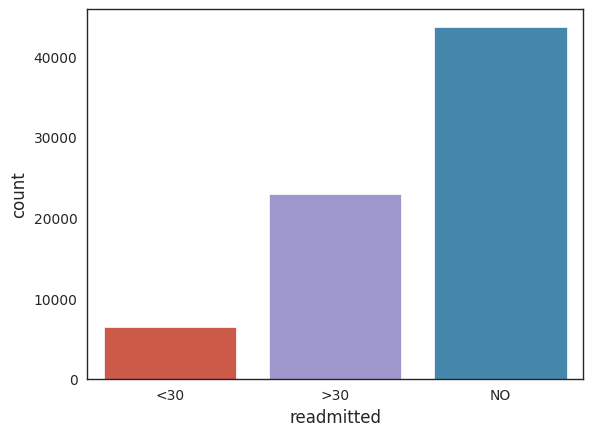

In [103]:
sns.countplot(
    data=diabetic_data,
    x='readmitted',
    hue='readmitted',
    order=['<30', '>30', 'NO']
)
plt.show()

In [104]:
diabetic_data['readmitted'] = diabetic_data['readmitted'].map(
    lambda x: 1 if x == '<30' else 0
)

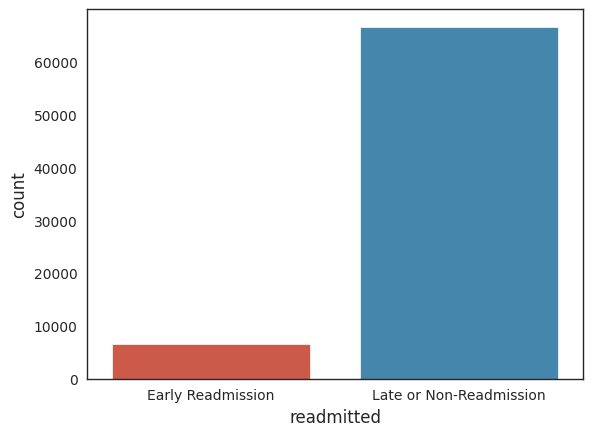

In [105]:
temp_data = diabetic_data.copy()
temp_data['readmitted'] = temp_data['readmitted'].map({1: 'Early Readmission', 0: 'Late or Non-Readmission'})

sns.countplot(
    data=temp_data,
    x='readmitted',
    hue='readmitted',
    order=['Early Readmission', 'Late or Non-Readmission']
)
plt.show()

In [106]:
# Get the percentages of early and late or non-readmissions
temp_data['readmitted'].value_counts(normalize=True) * 100


readmitted
Late or Non-Readmission    91.134461
Early Readmission           8.865539
Name: proportion, dtype: float64

#### 3.2.3 Discharge dispositions

Feature `discharge_disposition_id` is represented as a series of codes, representing discharge dispositions listed within the file `discharge_disposition_ids.csv`. We group them into five major classifications:

- Home / Home Care
- Transfer to another facility
- Expired (lease on life expired)
- Hospice Care
- Other (not included in the previous ones)

In [107]:
diabetic_data['discharge_disposition_id'].value_counts().sort_values(ascending=False)

discharge_disposition_id
1     45221
3      9044
6      8513
18     2511
2      1558
22     1438
11     1103
5       926
25      787
4       553
7       418
23      270
13      253
14      223
28       92
8        74
15       41
24       27
9         9
17        8
19        6
10        6
16        5
27        3
12        2
20        1
Name: count, dtype: int64

In [108]:
def map_discharge_disposition(discharge_disp_id):
    # Handle missing values
    if pd.isnull(discharge_disp_id):
        return None
    
    if discharge_disp_id in [1, 6, 8]:
        return 'Home / Home Care'
    elif discharge_disp_id in [2, 3, 4, 5, 10, 15, 16, 17, 22, 23, 24, 27, 28, 29, 30]:
        return 'Transfer to Another Facility'
    elif discharge_disp_id in [11, 19, 20, 21]:
        return 'Expired'
    elif discharge_disp_id in [13, 14]:
        return 'Hospice Care'
    else:
        return 'Other'

In [109]:
diabetic_data['discharge_disposition_group'] = diabetic_data['discharge_disposition_id'].apply(map_discharge_disposition)

We combine the cases of early readmission and late or non-readmission for all discharge disposition categories. We can clearly see that 'Home / Home care' is the predominant one. Also 'Trasfer to another facility' is interesting, since it stands out from the others by percentage of readmission.

In [110]:
discharge_counts = get_readmission_distribution('discharge_disposition_group', 'Discharge Disposition Group', sort_by='Total')
discharge_counts

Discharge Disposition Group  No Readmission  Readmission  Total  \
0              Home / Home Care           49817         3991  53808   
1  Transfer to Another Facility           11851         2120  13971   
2                         Other            3377          350   3727   
3                       Expired            1110            0   1110   
4                  Hospice Care             457           19    476   

   Percentage  
0    0.074171  
1    0.151743  
2    0.093909  
3    0.000000  
4    0.039916

We simply create two boolean feature, one for when the patient is sent home or to home care, and another for when the patient is transferred to another facility, and we discard all other sources of admission.

In [111]:
diabetic_data['discharge_home'] = diabetic_data['discharge_disposition_group'].apply(
    lambda disch: 1 if disch == "Home / Home Care" else 0
)

diabetic_data['discharge_transfer'] = diabetic_data['discharge_disposition_group'].apply(
    lambda disch: 1 if disch == "Transfer to Another Facility" else 0
)

As a final touch, we also remove all expired (dead) patients and those sent to hospice care, since they do not count towards readmission.

In [112]:
diabetic_data = diabetic_data[
    ~diabetic_data['discharge_disposition_group'].isin(['Expired', 'Hospice Care'])
]
diabetic_data.reset_index(drop=True, inplace=True)

#### 3.2.4 Age

Feature `age` is represented as a series of age ranges. Let's try to visualize the patients' age distribution.

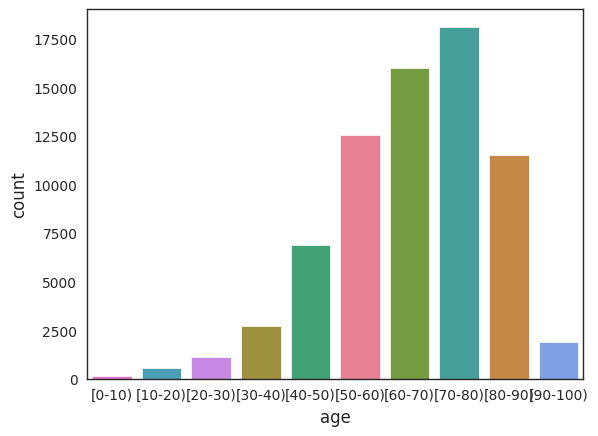

In [113]:
sns.countplot(
    data=diabetic_data,
    x='age',
    hue='age',
    order=[
        '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
        '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
    ]
)
plt.show()

Higher ages are the predominant ones, and also the ones with higher percentages of readmission.

In [114]:
age_counts = get_readmission_distribution('age', 'Age', sort_by='Total')
age_counts

Age  No Readmission  Readmission  Total  Percentage
0   [70-80)           16247         1865  18112    0.102970
1   [60-70)           14553         1448  16001    0.090494
2   [50-60)           11642          904  12546    0.072055
3   [80-90)           10262         1243  11505    0.108040
4   [40-50)            6395          511   6906    0.073994
5   [30-40)            2528          192   2720    0.070588
6  [90-100)            1711          185   1896    0.097574
7   [20-30)            1048           84   1132    0.074205
8   [10-20)             509           26    535    0.048598
9    [0-10)             150            3    153    0.019608

All age groups have a mathematical ordering (some are bigger than others, and viceversa), so it makes sense to apply ordinal encoding.

In [115]:
encoder = OrdinalEncoder()
encoder.fit(diabetic_data[['age']])
diabetic_data['age'] = encoder.transform(diabetic_data[['age']])

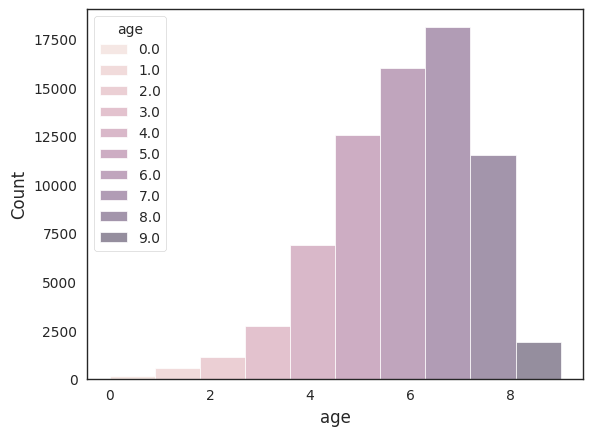

In [116]:
sns.histplot(
    data=diabetic_data,
    x='age',
    hue='age',
    bins=10
)
plt.show()

#### 3.2.5 Race

Let's try to enable racism in our models with the feature `race`.

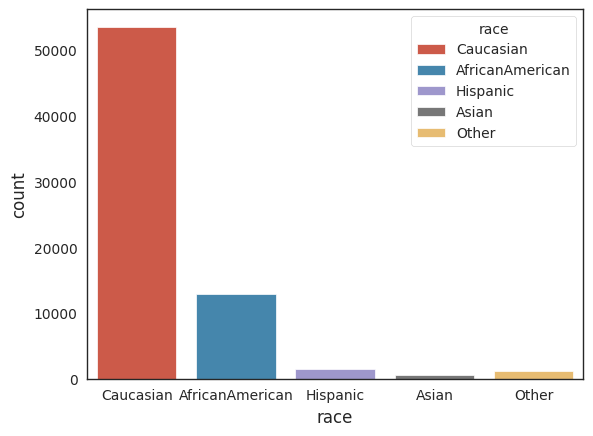

In [117]:
sns.countplot(
    data=diabetic_data,
    x='race',
    hue='race'
)
plt.show()

The only thing we are able to see is that most people are Caucasian. The distribution of readmission does not highlight anything particular either. Guess we can't make racist elmo then.

In [118]:
race_counts = get_readmission_distribution('race', 'Race', sort_by='Total')
race_counts

Race  No Readmission  Readmission  Total  Percentage
0        Caucasian           48590         4966  53556    0.092725
1  AfricanAmerican           11792         1127  12919    0.087236
2         Hispanic            1404          124   1528    0.081152
3            Other            1087           80   1167    0.068552
4            Asian             455           42    497    0.084507

#### 3.2.6 Gender

Let's try to enable sexism in our models with the feature `gender`.

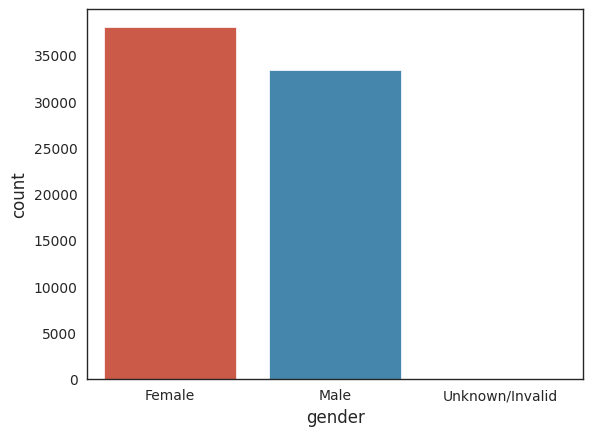

In [119]:
sns.countplot(
    data=diabetic_data,
    x='gender',
    hue='gender'
)
plt.show()

There is a fairly equal distribution between male and female, plus three 'unknown/invalid' genders... MOFOs who decided to call 'other' genders 'invalid' are quite rude, but hey... 2000s.

That topic aside, the percentages of readmission are the same between both groups, there is no visible variance between them.

In [120]:
gender_counts = get_readmission_distribution('gender', 'Gender', sort_by='Total')
gender_counts

Gender  No Readmission  Readmission  Total  Percentage
0           Female           34602         3465  38067    0.091024
1             Male           30440         2996  33436    0.089604
2  Unknown/Invalid               3            0      3    0.000000

Despite no variance in readmission rates, both classes are quite balanced. A model might be able to pick up relationships with other features that are not immediately visible to the naked eye, so we'll keep it.

Since there are only three cases of 'other' genders, we'll turn them to the most common, and create a boolean feature for gender.

In [121]:
diabetic_data.loc[diabetic_data['gender'] == 'Unknown/Invalid', 'gender'] = 'Female'

diabetic_data['gender'] = diabetic_data['gender'].map({
    'Female': 1,
    'Male': 0
})

#### 3.2.7 Time in hospital

Feature `time_in_hospital` is used to represent the amount of days spent in hospital by the patient. Let's see its distribution.

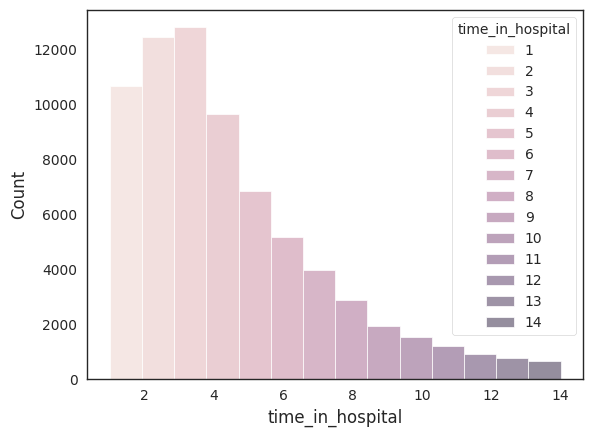

In [122]:
sns.histplot(
    data=diabetic_data,
    x='time_in_hospital',
    hue='time_in_hospital',
    bins=14
)
plt.show()

It's pretty clear that early-readmitted patients tend to have more days in hospital, and also a higher mean of hospital days.

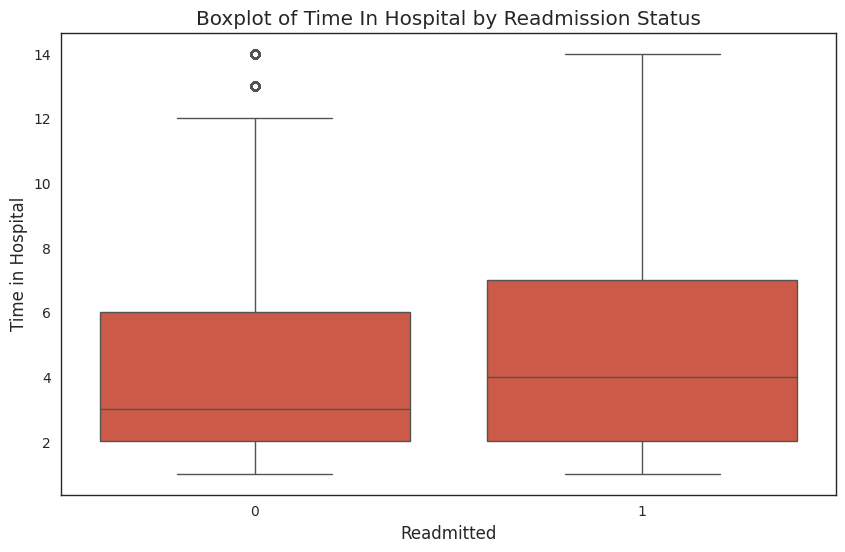

In [123]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='time_in_hospital')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Time in Hospital')

# Show the plot
plt.show()

There is also a visible relationship with the age group of the patient. The higher the age, the more days in hospital are encountered.

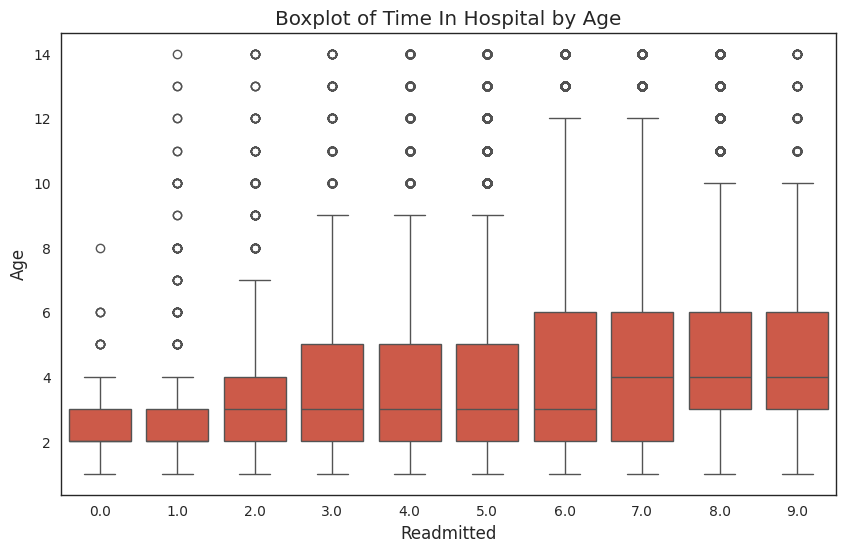

In [124]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='age', y='time_in_hospital')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Age')
plt.xlabel('Readmitted')
plt.ylabel('Age')

# Show the plot
plt.show()

Let's apply a global z-score filtering of the time spent in hospital.

In [127]:
zscore_filtering(data=diabetic_data, column='time_in_hospital', threshold=3, method='capping', dtype=float)

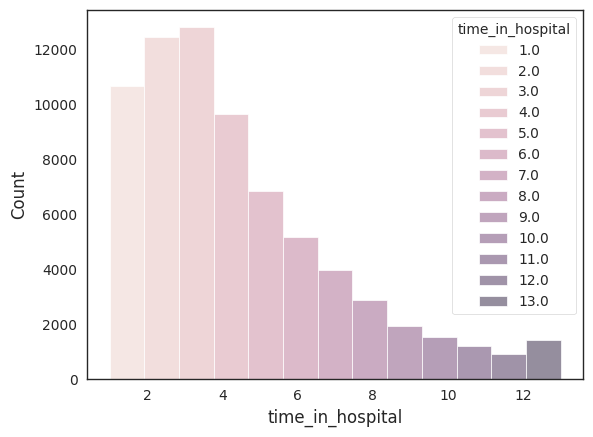

In [128]:
sns.histplot(
    data=diabetic_data,
    x='time_in_hospital',
    hue='time_in_hospital',
    bins=13
)
plt.show()

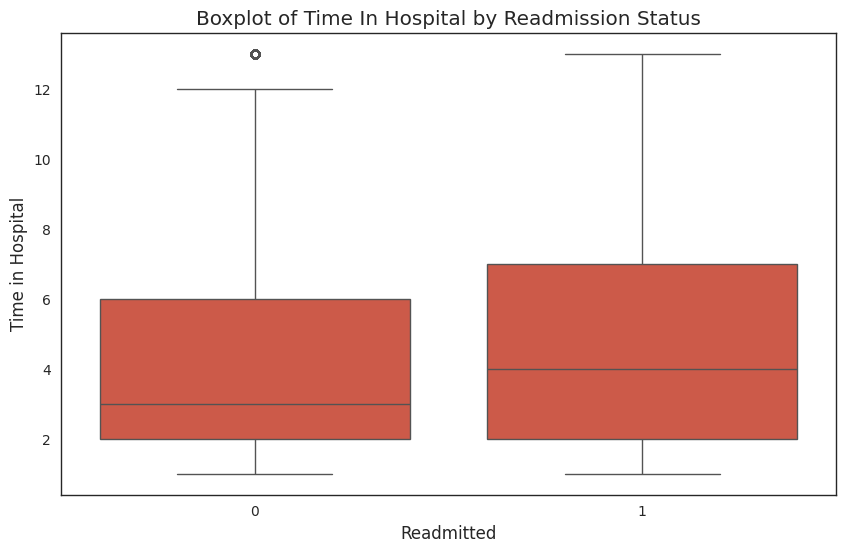

In [129]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='time_in_hospital')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Time in Hospital')

# Show the plot
plt.show()

#### 3.2.8 Lab procedures

Feature `num_lab_procedures` is used to represent the number of laboratory procedures conducted on the patient. Let's see its distribution.

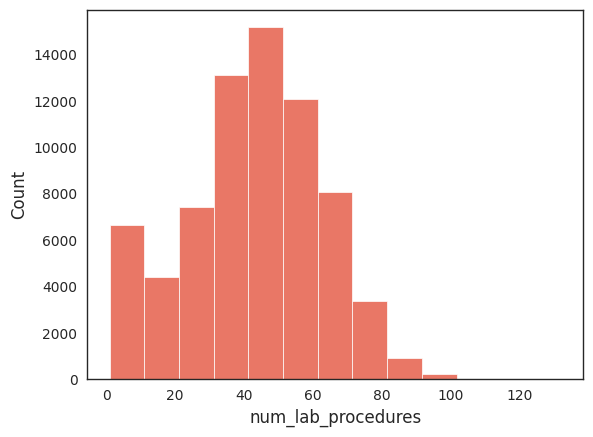

In [130]:
sns.histplot(
    data=diabetic_data,
    x='num_lab_procedures',
    binwidth=10
)
plt.show()

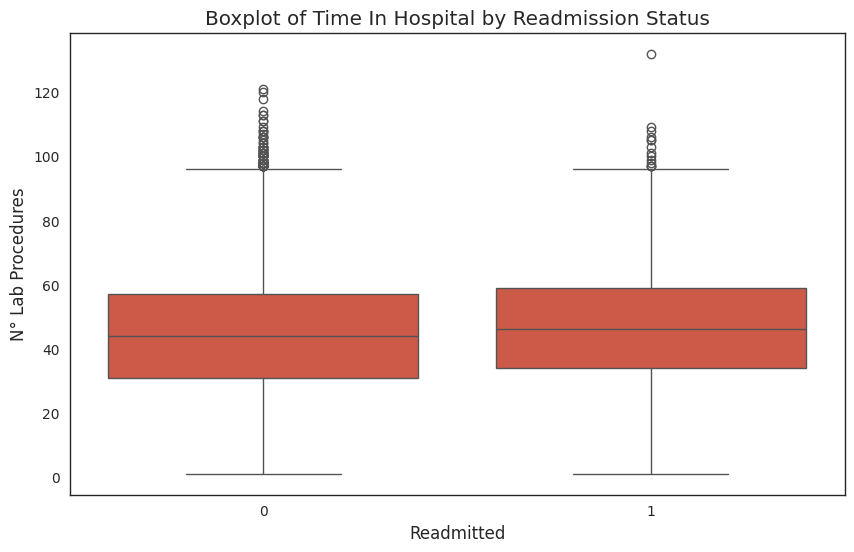

In [131]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_lab_procedures')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Lab Procedures')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [134]:
zscore_filtering(data=diabetic_data, column='num_lab_procedures', threshold=2.5, method='mean')

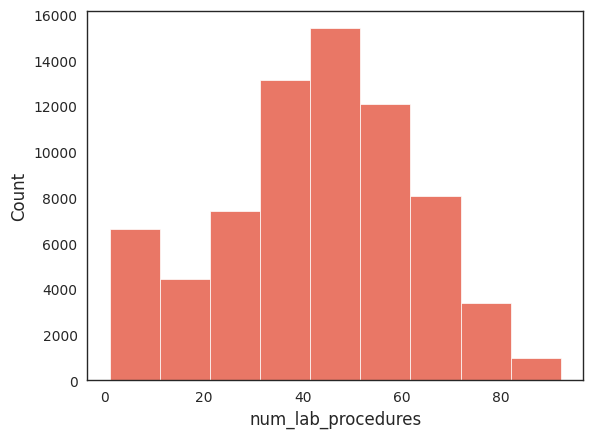

In [135]:
sns.histplot(
    data=diabetic_data,
    x='num_lab_procedures',
    binwidth=10
)
plt.show()

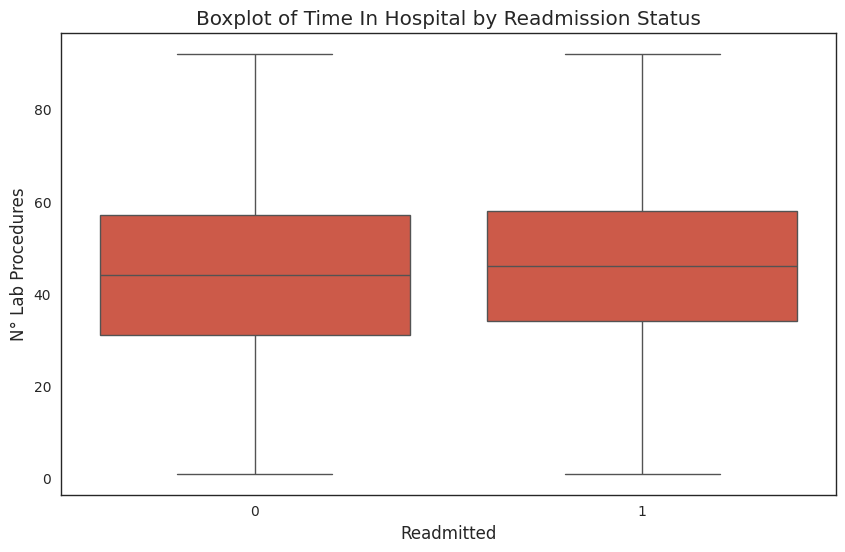

In [136]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_lab_procedures')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Lab Procedures')

# Show the plot
plt.show()

#### 3.2.9 Non-lab procedures

Feature `num_procedures` is used to represent the number of non-laboratory procedures conducted on the patient. Let's see its distribution.

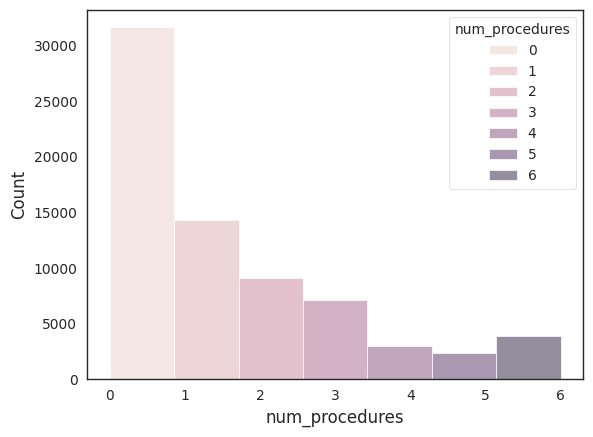

In [137]:
sns.histplot(
    data=diabetic_data,
    x='num_procedures',
    hue='num_procedures',
    bins=7
)
plt.show()

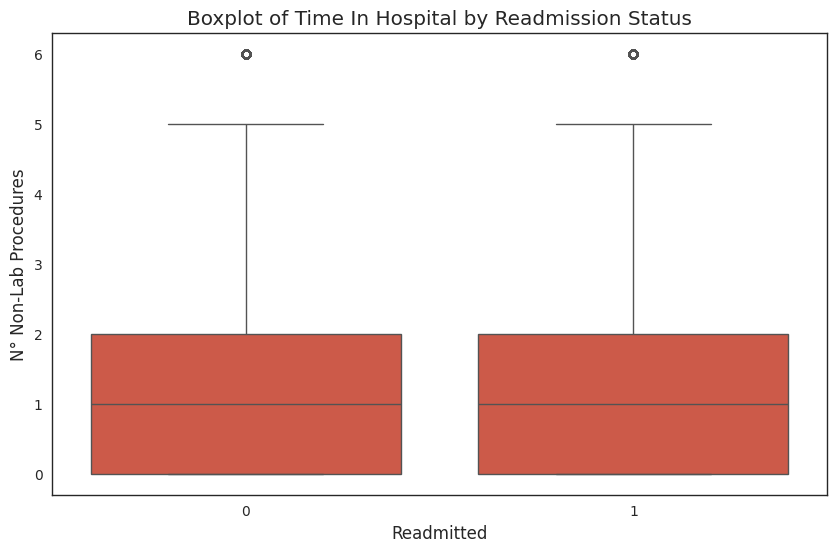

In [138]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_procedures')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Non-Lab Procedures')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [142]:
zscore_filtering(data=diabetic_data, column='num_procedures', threshold=3, method='mean')

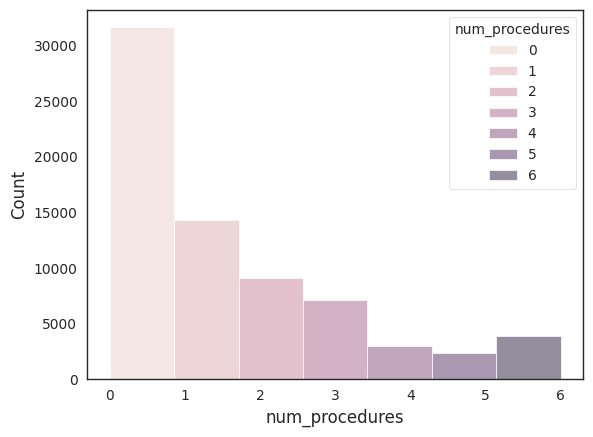

In [143]:
sns.histplot(
    data=diabetic_data,
    x='num_procedures',
    hue='num_procedures',
    bins=7
)
plt.show()

#### 3.2.10 Medications number

Feature `num_medications` is used to represent the number of medications subministered to a patient. Let's see its distribution.

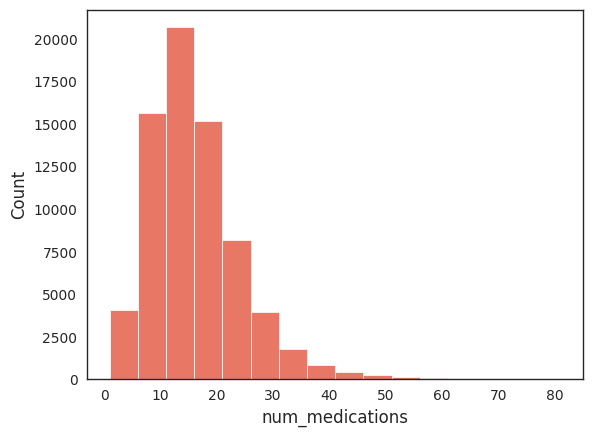

In [144]:
sns.histplot(
    data=diabetic_data,
    x='num_medications',
    binwidth=5
)
plt.show()

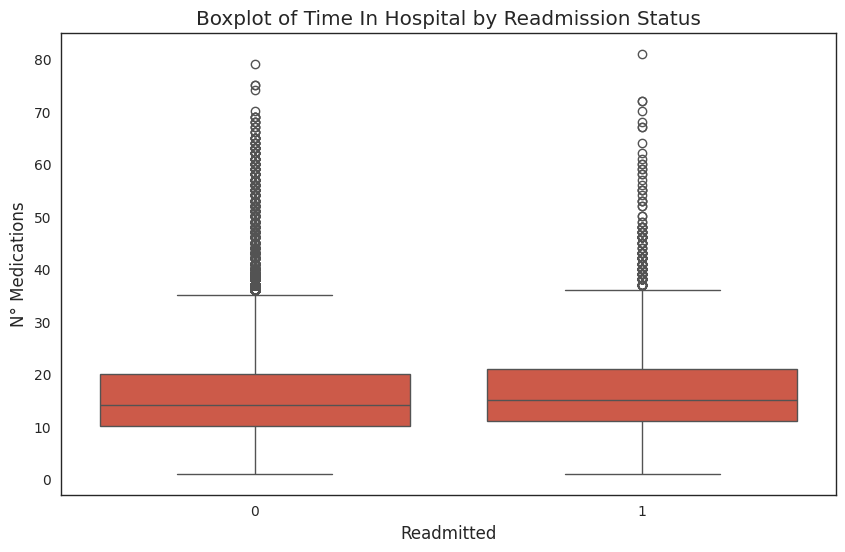

In [145]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_medications')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Medications')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [148]:
zscore_filtering(data=diabetic_data, column='num_medications', threshold=2.5, method='capping')

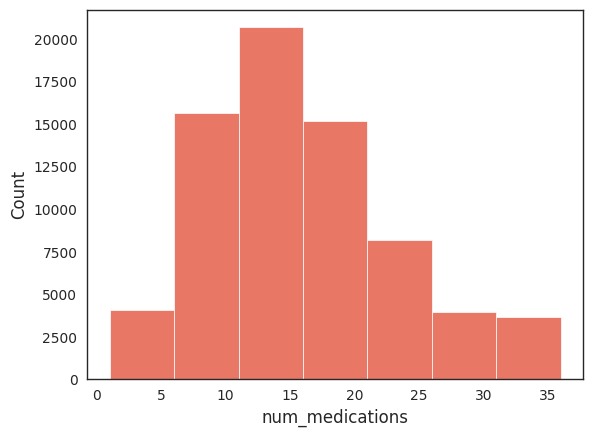

In [149]:
sns.histplot(
    data=diabetic_data,
    x='num_medications',
    binwidth=5
)
plt.show()

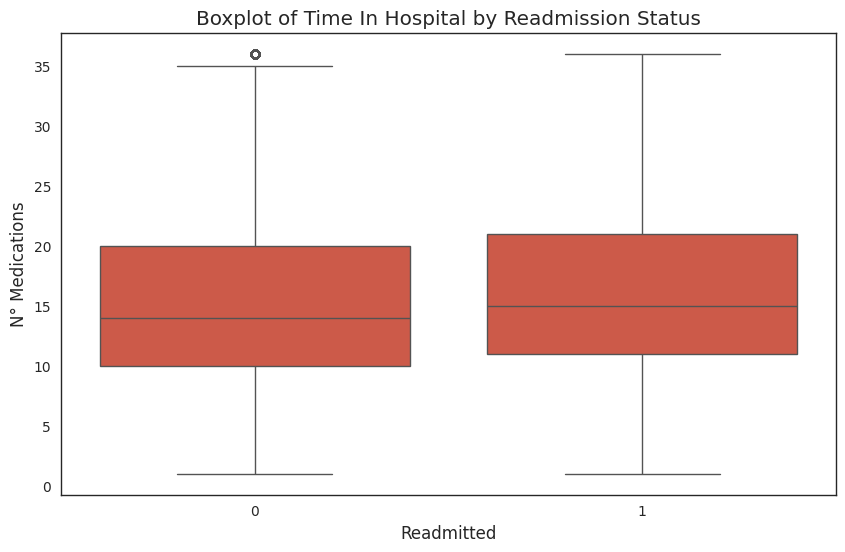

In [150]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_medications')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Medications')

# Show the plot
plt.show()

#### 3.2.11 Diagnoses number

Feature `num_diagnoses` is used to represent the number of diagnoses discovered on a patient. Let's see its distribution.

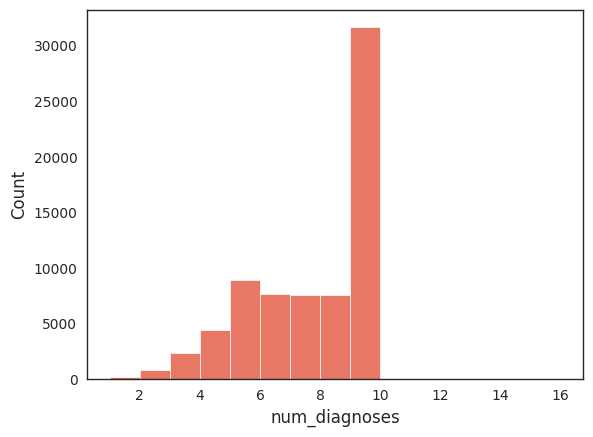

In [151]:
sns.histplot(
    data=diabetic_data,
    x='num_diagnoses',
    binwidth=1
)
plt.show()

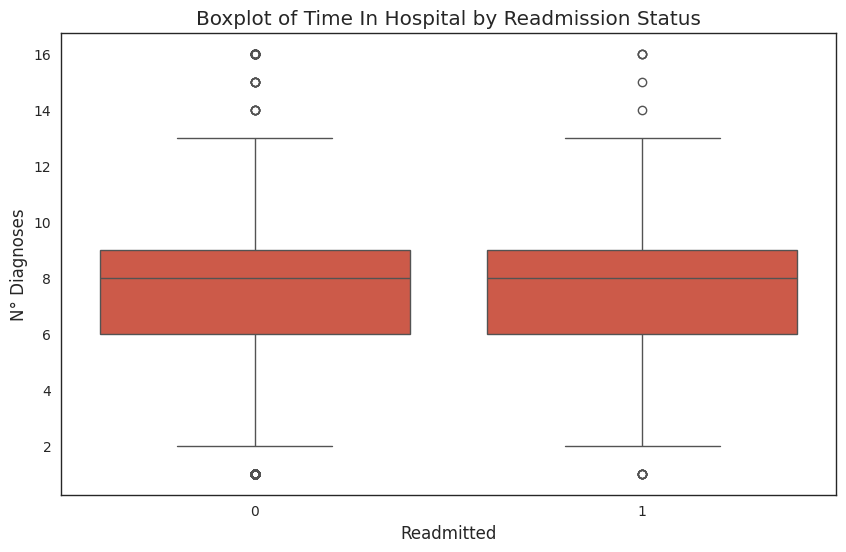

In [152]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_diagnoses')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Diagnoses')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [155]:
zscore_filtering(data=diabetic_data, column='num_diagnoses', threshold=2.5, method='mean')

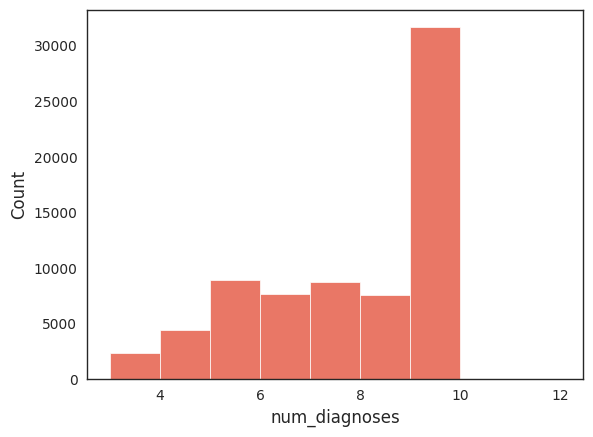

In [156]:
sns.histplot(
    data=diabetic_data,
    x='num_diagnoses',
    binwidth=1
)
plt.show()

#### 3.2.12 Inpatient visits

Feature `num_inpatient` is used to represent the number of impatient visits by a patient. Let's see its distribution.

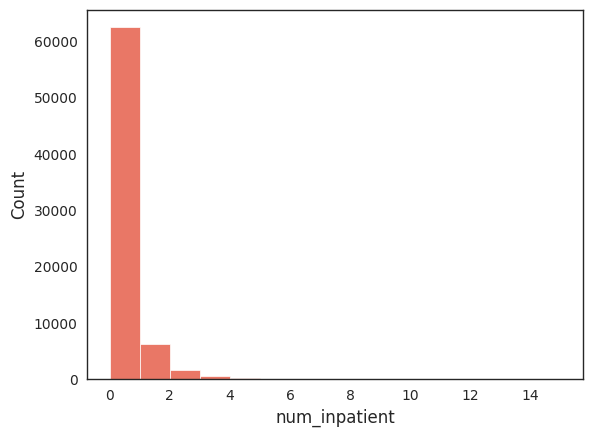

In [157]:
sns.histplot(
    data=diabetic_data,
    x='num_inpatient',
    binwidth=1
)
plt.show()

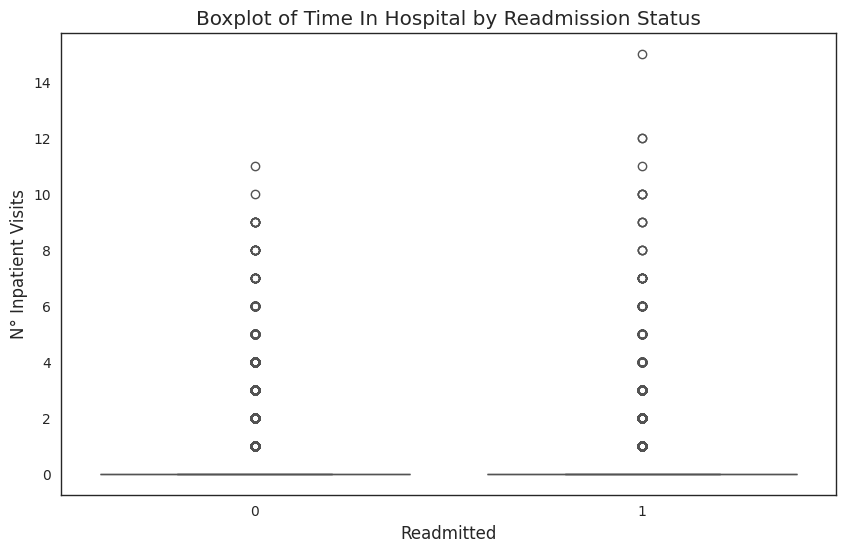

In [158]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_inpatient')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Inpatient Visits')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [161]:
zscore_filtering(data=diabetic_data, column='num_inpatient', threshold=3, method='capping')

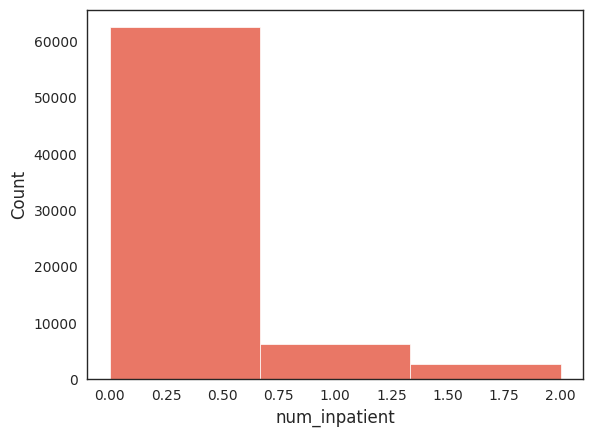

In [162]:
sns.histplot(
    data=diabetic_data,
    x='num_inpatient',
    bins=3
)
plt.show()

#### 3.2.13 Outpatient visits

Feature `num_outpatient` is used to represent the number of outpatient visits by a patient. Let's see its distribution.

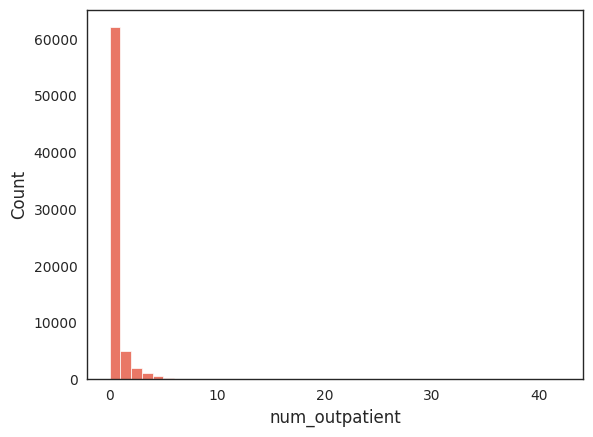

In [163]:
sns.histplot(
    data=diabetic_data,
    x='num_outpatient',
    binwidth=1
)
plt.show()

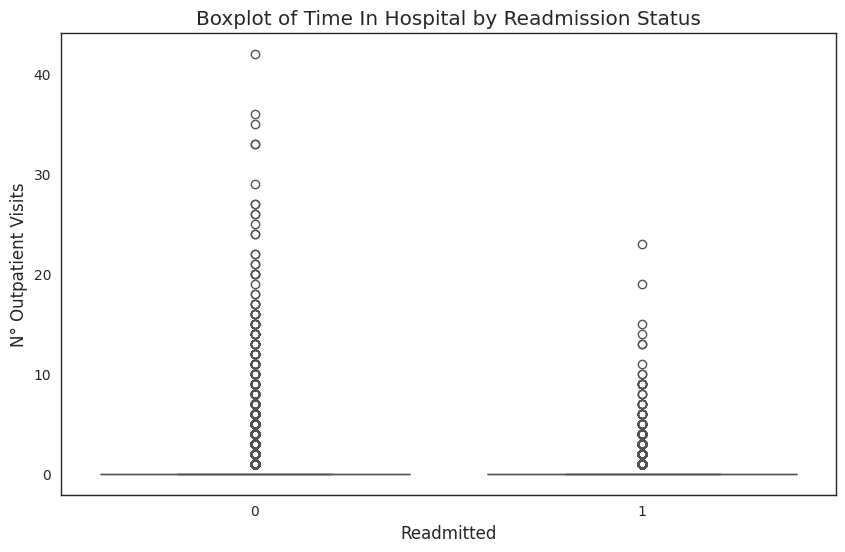

In [164]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_outpatient')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Outpatient Visits')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [167]:
zscore_filtering(data=diabetic_data, column='num_outpatient', threshold=3, method='capping')

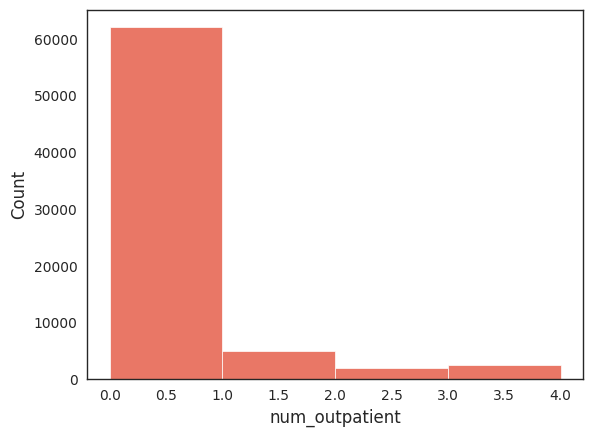

In [168]:
sns.histplot(
    data=diabetic_data,
    x='num_outpatient',
    bins=4
)
plt.show()

#### 3.2.14 Emergency visits

Feature `num_emergency` is used to represent the number of emergency visits by a patient. Let's see its distribution.

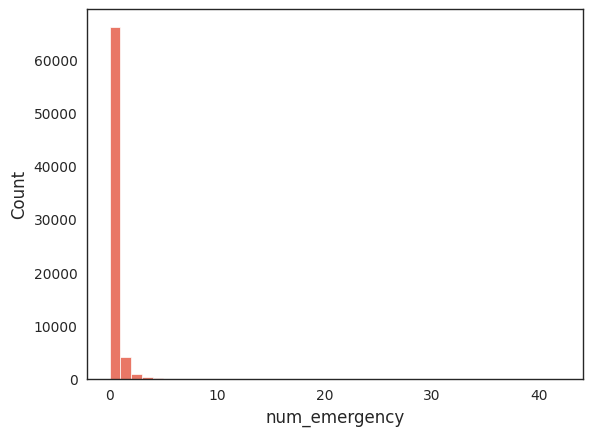

In [169]:
sns.histplot(
    data=diabetic_data,
    x='num_emergency',
    binwidth=1
)
plt.show()

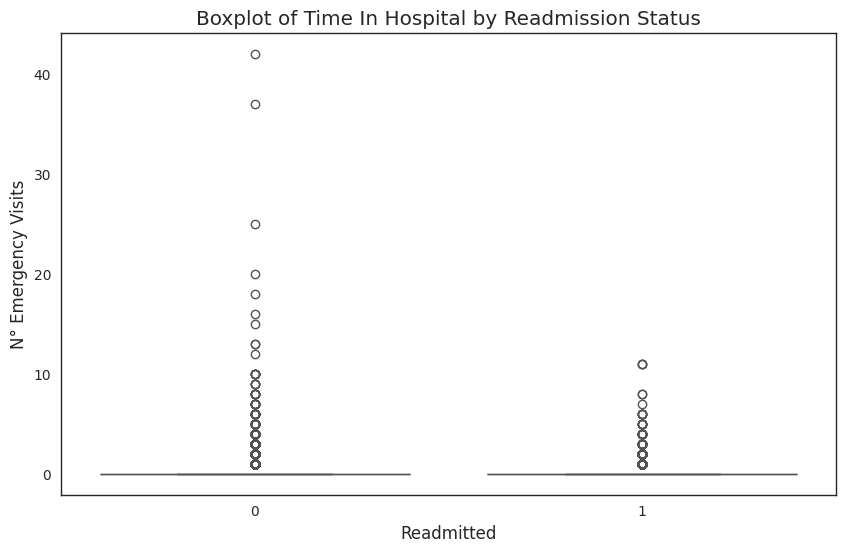

In [170]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_emergency')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('N° Emergency Visits')

# Show the plot
plt.show()

Let's apply a global z-score filtering.

In [173]:
zscore_filtering(data=diabetic_data, column='num_emergency', threshold=3, method='capping')

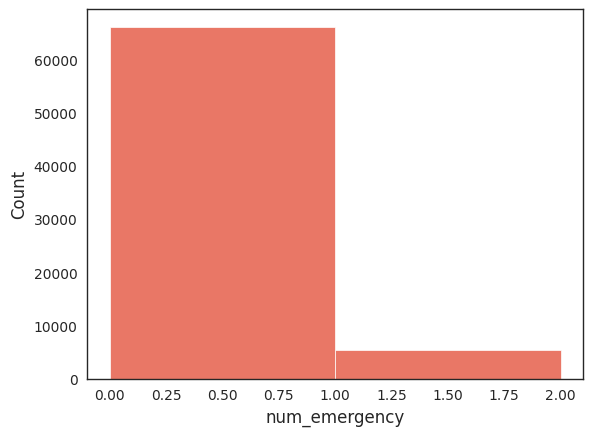

In [174]:
sns.histplot(
    data=diabetic_data,
    x='num_emergency',
    bins=2
)
plt.show()

#### 3.2.15 Diagnoses

It doesn't reallt make sense that some primary diagnoses are missing, we we will just impute them with the most common value. It makes sense instead for secondary and tertiary diagnoses to be missing (none were found for the patient), so we'll just consider them as missing.

In [175]:
imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
diabetic_data['diag_1'] = pd.DataFrame(imputer.fit_transform(diabetic_data[['diag_1']]))

The `diag_1`, `diag_2`, and `diag_3` columns in the dataset represent diagnosis codes, encoded as ICD-9-CM (International Classification of Diseases, 9th Revision, Clinical Modification) codes. We would like to reduce their numbers by grouping them into categories. Let's start by using the official classifications from ICD-9-CM.

In [176]:
def map_icd9_to_category(code):
    if not code:
        return "Missing"
    try:
        code = str(code).strip()
        if code.startswith("V"):
            return "Supplementary (Factor Influencing Health)"
        elif code.startswith("E"):
            return "External Cause of Injury"
        else:
            num_code = float(code)
            if 250 <= num_code < 251:
                return "Diabetes"
            elif 1 <= num_code < 140:
                return "Infectious and Parasitic"
            elif 140 <= num_code < 240:
                return "Neoplasm"
            elif 240 <= num_code < 280:
                return "Endocrine, Nutritional, or Metabolic"
            elif 280 <= num_code < 290:
                return "Blood Disease"
            elif 290 <= num_code < 320:
                return "Mental Disorder"
            elif 320 <= num_code < 390:
                return "Nervous System Disease"
            elif 390 <= num_code < 460:
                return "Circulatory System Disease"
            elif 460 <= num_code < 520:
                return "Respiratory System Disease"
            elif 520 <= num_code < 580:
                return "Digestive System Disease"
            elif 580 <= num_code < 630:
                return "Genitourinary System Disease"
            elif 630 <= num_code < 680:
                return "Pregnancy, Childbirth, or Puerperium"
            elif 680 <= num_code < 710:
                return "Skin and Subcutaneous Tissue Disease"
            elif 710 <= num_code < 740:
                return "Musculoskeletal System Disease"
            elif 740 <= num_code < 760:
                return "Congenital Anomaly"
            elif 760 <= num_code < 780:
                return "Certain Condition Originating in the Perinatal Period"
            elif 780 <= num_code < 800:
                return "Symptom, Sign, and Ill-Defined Condition"
            elif 800 <= num_code < 1000:
                return "Injury and Poisoning"
            else:
                return "Other"
    except ValueError:
        return "Missing"

In [177]:
diabetic_data['diag_1_group'] = diabetic_data['diag_1'].apply(map_icd9_to_category)
diabetic_data['diag_2_group'] = diabetic_data['diag_2'].apply(map_icd9_to_category)
diabetic_data['diag_3_group'] = diabetic_data['diag_3'].apply(map_icd9_to_category)

We combine the cases of early readmission and late or non-readmission for all diagnoses categories, by summing contributions from all features (`diag_1`, `diag_2` and `diag_3`). We can see that the most common diagnoses across all three (primary, seconday and tertiary) are:

- Circulatory System Disease
- Diabetes
- Respiratory System Disease
- Endocrine, Nutritional, or Metabolic
- Genitourinary System Disease

In [178]:
# Compute readmission counts for each diagnosis group
readmission_counts_1 = get_readmission_distribution('diag_1_group', 'Diagnosis Group')
readmission_counts_2 = get_readmission_distribution('diag_2_group', 'Diagnosis Group')
readmission_counts_3 = get_readmission_distribution('diag_3_group', 'Diagnosis Group')

# Concatenate the dataframes
all_readmission_counts = pd.concat([readmission_counts_1, readmission_counts_2, readmission_counts_3])

# Group by 'diag_group' and sum the contributions
total_readmission_counts = all_readmission_counts.groupby('Diagnosis Group').sum().reset_index()

# Add a 'Total' column
total_readmission_counts['Total'] = total_readmission_counts['Readmission'] + total_readmission_counts['No Readmission']

# Add readmission 'Percentage' column
total_readmission_counts['Percentage'] = total_readmission_counts['Readmission'] / total_readmission_counts['Total']

# Sort by 'Total' in descending order
total_readmission_counts.sort_values(by='Total', ascending=False, inplace=True)

# Reset index
total_readmission_counts.reset_index(drop=True, inplace=True)

total_readmission_counts

Diagnosis Group  No Readmission  Readmission  \
0                  Circulatory System Disease           59076         6069   
1                                    Diabetes           26040         2514   
2                  Respiratory System Disease           16038         1604   
3        Endocrine, Nutritional, or Metabolic           13018         1163   
4                Genitourinary System Disease           11395         1175   
5    Symptom, Sign, and Ill-Defined Condition           11071          950   
6                    Digestive System Disease           10732         1000   
7                        Injury and Poisoning            7256          856   
8              Musculoskeletal System Disease            6288          565   
9                             Mental Disorder            5171          515   
10       Skin and Subcutaneous Tissue Disease            5058          607   
11                                   Neoplasm            4778          588   
12  Supplementary (Factor Influencing Health)            4416          414   
13                              Blood Disease            4128          417   
14                   Infectious and Parasitic            3871          397   
15                     Nervous System Disease            2751          296   
16                   External Cause of Injury            1374          166   
17                                    Missing            1308           28   
18       Pregnancy, Childbirth, or Puerperium            1179           45   
19                         Congenital Anomaly             187           14   

    Total  Percentage  
0   65145    0.093161  
1   28554    0.088044  
2   17642    0.090919  
3   14181    0.082011  
4   12570    0.093477  
5   12021    0.079028  
6   11732    0.085237  
7    8112    0.105523  
8    6853    0.082446  
9    5686    0.090573  
10   5665    0.107149  
11   5366    0.109579  
12   4830    0.085714  
13   4545    0.091749  
14   4268    0.093018  
15   3047    0.097145  
16   1540    0.107792  
17   1336    0.020958  
18   1224    0.036765  
19    201    0.069652

We also want to give an in-depth look at the primary diagnoses `diag_1`, since it should be the most important. We can see that the most common diagnoses are:

- Circulatory System Disease
- Respiratory System Disease
- Digestive System Disease	
- Diabetes
- Symptom, Sign, and Ill-Defined Condition

In [179]:
# Add a 'Total' column
readmission_counts_1

Diagnosis Group  No Readmission  Readmission  \
0                  Circulatory System Disease           19641         2107   
1                  Respiratory System Disease            6084          561   
2                    Digestive System Disease            5950          519   
3                                    Diabetes            5329          548   
4    Symptom, Sign, and Ill-Defined Condition            5277          353   
5                        Injury and Poisoning            4289          523   
6              Musculoskeletal System Disease            3781          345   
7                Genitourinary System Disease            3179          315   
8                                    Neoplasm            2330          235   
9        Endocrine, Nutritional, or Metabolic            1710          172   
10       Skin and Subcutaneous Tissue Disease            1679          154   
11                   Infectious and Parasitic            1559          168   
12                            Mental Disorder            1420          170   
13  Supplementary (Factor Influencing Health)             810          125   
14                     Nervous System Disease             804           70   
15                              Blood Disease             597           68   
16       Pregnancy, Childbirth, or Puerperium             565           26   
17                         Congenital Anomaly              40            2   
18                   External Cause of Injury               1            0   

    Total  Percentage  
0   21748    0.096882  
1    6645    0.084424  
2    6469    0.080229  
3    5877    0.093245  
4    5630    0.062700  
5    4812    0.108687  
6    4126    0.083616  
7    3494    0.090155  
8    2565    0.091618  
9    1882    0.091392  
10   1833    0.084015  
11   1727    0.097279  
12   1590    0.106918  
13    935    0.133690  
14    874    0.080092  
15    665    0.102256  
16    591    0.043993  
17     42    0.047619  
18      1    0.000000

Both the primary diagnoses and the agglomerate share the circulatory, respiratory, and diabetes diseases as most common conditions. But primary diagnoses are more focused on digestive diseases and symptoms, rather than endocrine and genitourinary diseases.

Since their combined total occurrences are fairly similar, and since their readmission percentages are also close, we choose to keep digestive diseases and symptoms.

In [180]:
def map_diag_categories_to_final_category(diag_group):
    if diag_group in [
        'Circulatory System Disease', 'Symptom, Sign, and Ill-Defined Condition',
        'Diabetes', 'Respiratory System Disease', 'Digestive System Disease'
    ]:
        return diag_group
    else:
        return 'Other'

In [181]:
diabetic_data['diag_1_group'] = diabetic_data['diag_1_group'].apply(map_diag_categories_to_final_category)
diabetic_data['diag_2_group'] = diabetic_data['diag_2_group'].apply(map_diag_categories_to_final_category)
diabetic_data['diag_3_group'] = diabetic_data['diag_3_group'].apply(map_diag_categories_to_final_category)

Finally, we want to generate a boolean feature for all five types of conditions. These features will be positive whenever any original diagnosis (primary, secondary or tertiary) belongs to that category. The end result is that we have to deal with only five diagnoses features (and not a whole lot of them), which are also much more descriptive than the original ones.

In [182]:
diabetic_data['diag_circulatory'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Circulatory System Disease' for diag_group in row]), axis=1
).astype(int)

diabetic_data['diag_diabetes'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Diabetes' for diag_group in row]), axis=1
).astype(int)

diabetic_data['diag_respiratory'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Respiratory System Disease' for diag_group in row]), axis=1
).astype(int)

diabetic_data['diag_digestive'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Digestive System Disease' for diag_group in row]), axis=1
).astype(int)

diabetic_data['diag_symptoms'] = diabetic_data[['diag_1_group', 'diag_2_group', 'diag_3_group']].apply(
    lambda row: any([diag_group == 'Symptom, Sign, and Ill-Defined Condition' for diag_group in row]), axis=1
).astype(int)

#### 3.2.16 Admission sources

Feature `admission_source_id` is represented as a series of codes, representing admission sources listed within the file `admission_source_ids.csv`. We group them into four major classifications:

- Referral
- Transfer from another facility
- Emergency or Law Enforcement
- Other (not included in the previous ones)

In [183]:
diabetic_data['admission_source_id'].value_counts().sort_values(ascending=False)

admission_source_id
7     38243
1     22122
17     4939
4      2551
6      1794
2       914
5       528
20      153
3       136
9        96
8        13
10        7
22        4
14        2
25        2
13        1
11        1
Name: count, dtype: int64

In [821]:
def map_admission_source(admission_src_id):
    # Handle missing values
    if pd.isnull(admission_src_id):
        return None
    
    if admission_src_id in [1, 2, 3]:
        return 'Referral'
    elif admission_src_id in [4, 5, 6, 10, 18, 22, 25, 26]:
        return 'Transfer from Another Facility'
    elif admission_src_id in [7, 8]:
        return 'Emergency or Law Enforcement'
    else:
        return 'Other'

In [822]:
diabetic_data['admission_source_group'] = diabetic_data['admission_source_id'].apply(map_admission_source)

We combine the cases of early readmission and late or non-readmission for all admission source categories. We can clearly see that 'Emergency' is the predominant one, also in terms of percentage of readmissions.

In [823]:
admission_counts = get_readmission_distribution('admission_source_group', 'Admission Source Group', sort_by='Total')
admission_counts

Admission Source Group  No Readmission  Readmission  Total  \
0    Emergency or Law Enforcement           34691         3565  38256   
1                        Referral           21154         2018  23172   
2                           Other            4726          466   5192   
3  Transfer from Another Facility            4474          412   4886   

   Percentage  
0    0.093188  
1    0.087088  
2    0.089753  
3    0.084323

We simply create a boolean feature representing whether the patient was admitted due to an emergency (or by law enforcement), and discard all other sources of admission.

In [824]:
diabetic_data['adm_emergency'] = diabetic_data['admission_source_group'].apply(
    lambda adm: 1 if adm == "Emergency or Law Enforcement" else 0
)

#### 3.2.17 Glucose serum test

Feature `max_glu_serum` is used to represent the outcome of the glucose serum test of a patient. Let's see its distribution.

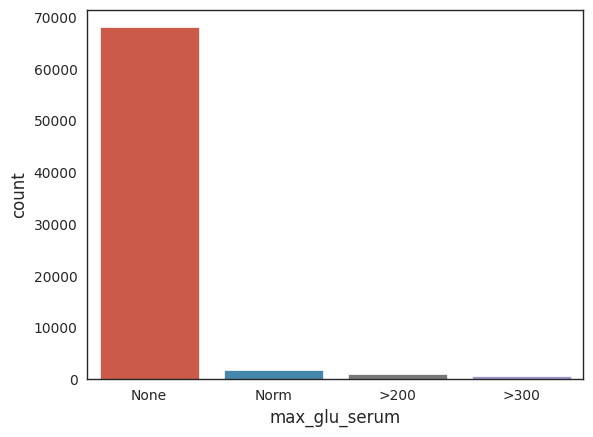

In [825]:
sns.countplot(
    data=diabetic_data,
    x='max_glu_serum',
    hue='max_glu_serum',
    order=['None', 'Norm', '>200', '>300']
)
plt.show()

#### 3.2.18 HbA1C test

Feature `A1Cresult` is used to represent the outcome of the A1c (hemoglobline) test of a patient. Let's see its distribution.

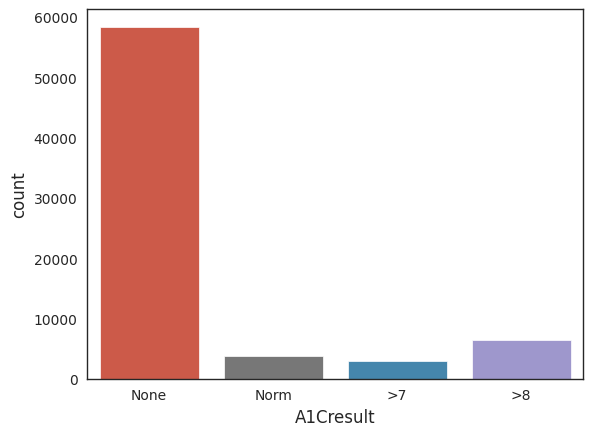

In [826]:
sns.countplot(
    data=diabetic_data,
    x='A1Cresult',
    hue='A1Cresult',
    order=['None', 'Norm', '>7', '>8']
)
plt.show()

#### 3.2.19 Diabetes medication and changes

Both `diabetes_med_change` and `diabetes_med_provided` can be seen as boolean values... so we turn them into boolean features.

In [827]:
# Making change and subministration of diabetes medication boolean
diabetic_data['diabetes_med_change'] = diabetic_data['diabetes_med_change'].replace(
    {
        'No': 0,
        'Ch': 1
    }
)
diabetic_data['diabetes_med_provided'] = diabetic_data['diabetes_med_provided'].replace(
    {
        'No': 0,
        'Yes': 1
    }
)

/tmp/ipykernel_5807/88342666.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['diabetes_med_change'] = diabetic_data['diabetes_med_change'].replace(
/tmp/ipykernel_5807/88342666.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['diabetes_med_provided'] = diabetic_data['diabetes_med_provided'].replace(


#### 3.2.20 Insulin

Let's see the distribution of values for `insulin`.

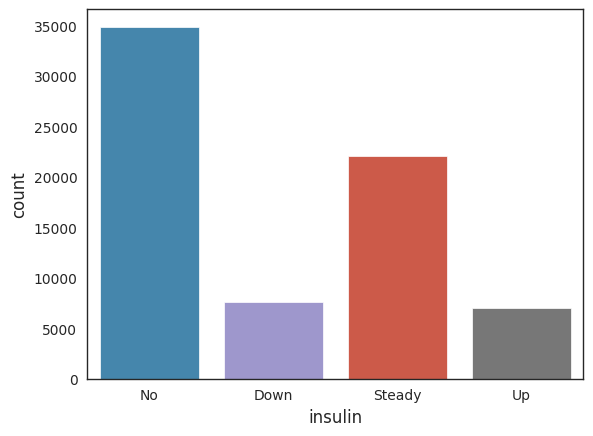

In [828]:
sns.countplot(
    data=diabetic_data,
    x='insulin',
    hue='insulin',
    order=['No', 'Down', 'Steady', 'Up']
)
plt.show()

Let's combine the variation of dosages under a unique value.

In [829]:
diabetic_data['insulin'] = diabetic_data['insulin'].map({
    'No': 'No',
    'Steady': 'Steady',
    'Down': 'Changed',
    'Up': 'Changed'
})

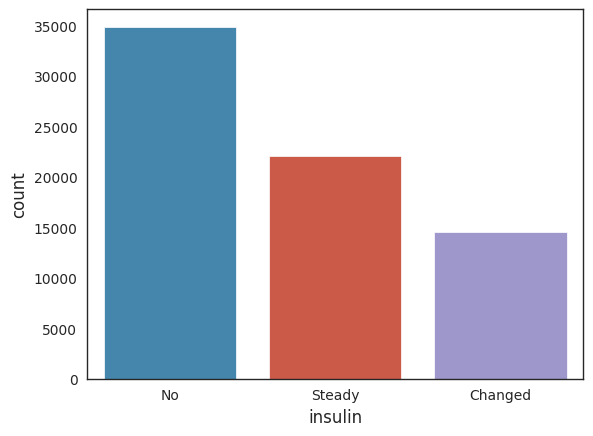

In [830]:
sns.countplot(
    data=diabetic_data,
    x='insulin',
    hue='insulin',
    order=['No', 'Steady', 'Changed']
)
plt.show()

Finally, let's create two boolean values, one for when the patient was given insulin, and the other one for when the insulin dosage was changed.

In [831]:
diabetic_data['insulin_given'] = diabetic_data['insulin'].apply(
    lambda x: 0 if x == 'No' else 1
)

diabetic_data['insulin_dose_changed'] = diabetic_data['insulin'].apply(
    lambda x: 1 if x == 'Changed' else 0
)

#### 3.2.21 Metformin

Let's see the distribution of values for `metformin`.

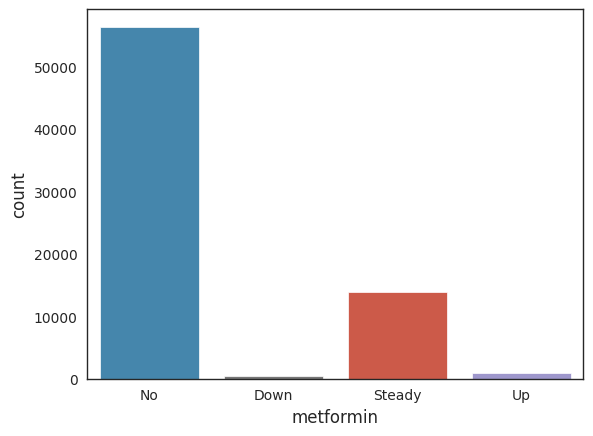

In [832]:
sns.countplot(
    data=diabetic_data,
    x='metformin',
    hue='metformin',
    order=['No', 'Down', 'Steady', 'Up']
)
plt.show()

Although it doesn't look promising, let's create a boolean feature for when metformin was given to the patient.

In [833]:
diabetic_data['metformin_given'] = diabetic_data['metformin'].apply(
    lambda x: 0 if x == 'No' else 1
)

#### 3.2.22 Medical specialties

Mapping **medical_specialty** to macro-categories.

In [834]:
diabetic_data['medical_specialty'].sort_values(ascending=True).unique()

array(['AllergyandImmunology', 'Anesthesiology',
       'Anesthesiology-Pediatric', 'Cardiology', 'Cardiology-Pediatric',
       'DCPTEAM', 'Dentistry', 'Dermatology', 'Emergency/Trauma',
       'Endocrinology', 'Endocrinology-Metabolism',
       'Family/GeneralPractice', 'Gastroenterology', 'Gynecology',
       'Hematology', 'Hematology/Oncology', 'Hospitalist',
       'InfectiousDiseases', 'InternalMedicine', 'Nephrology',
       'Neurology', 'Neurophysiology',
       'Obsterics&Gynecology-GynecologicOnco', 'Obstetrics',
       'ObstetricsandGynecology', 'Oncology', 'Ophthalmology',
       'Orthopedics', 'Orthopedics-Reconstructive', 'Osteopath',
       'Otolaryngology', 'OutreachServices', 'Pathology', 'Pediatrics',
       'Pediatrics-CriticalCare', 'Pediatrics-EmergencyMedicine',
       'Pediatrics-Endocrinology', 'Pediatrics-Hematology-Oncology',
       'Pediatrics-Neurology', 'Pediatrics-Pulmonology', 'Perinatology',
       'PhysicalMedicineandRehabilitation', 'PhysicianNotFound'

In [835]:
def map_medical_specialty(medical_specialty):
    # Handle missing values
    if pd.isnull(medical_specialty):
        return 'Missing'
    
    if medical_specialty in [
        'Family/GeneralPractice', 'InternalMedicine', 'Resident', 'Hospitalist'
    ]:
        return 'Internal Medicine'
    
    elif medical_specialty in [
        'Cardiology', 'Cardiology-Pediatric', 'Surgery-Cardiovascular',
        'Surgery-Cardiovascular/Thoracic', 'Surgery-Thoracic', 'Surgery-Vascular'
    ]:
        return 'Cardiology & Cardiovascular'
    
    elif medical_specialty in [
        'Surgery-General', 'Surgery-Pediatric', 'Surgery-Colon&Rectal',
        'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',
        'Surgery-Neuro', 'SurgicalSpecialty', 'Surgeon'
    ]:
        return 'Surgery'
    
    elif medical_specialty in [
        'Psychiatry', 'Psychiatry-Addictive', 'Psychiatry-Child/Adolescent', 'Psychology'
    ]:
        return 'Mental Health'
    
    elif medical_specialty in [
        'Pulmonology', 'InfectiousDiseases'
    ]:
        return 'Pulmonary $ Infectious Diseases'
    
    elif medical_specialty == 'Emergency/Trauma':
        return 'Acute & Emergency Care'
    
    else:
        return 'Other'

In [836]:
diabetic_data['medical_specialty_group'] = diabetic_data['medical_specialty'].apply(map_medical_specialty)

In [837]:
specialty_counts = get_readmission_distribution('medical_specialty_group', 'Medical Specialty Group', sort_by='Total')
specialty_counts

Medical Specialty Group  No Readmission  Readmission  Total  \
0                          Missing           30131         2730  32861   
1                Internal Medicine           14833         1702  16535   
2                            Other            6860          787   7647   
3      Cardiology & Cardiovascular            5092          454   5546   
4           Acute & Emergency Care            4232          375   4607   
5                          Surgery            2635          256   2891   
6                    Mental Health             642           88    730   
7  Pulmonary $ Infectious Diseases             620           69    689   

   Percentage  
0    0.083077  
1    0.102933  
2    0.102916  
3    0.081861  
4    0.081398  
5    0.088551  
6    0.120548  
7    0.100145

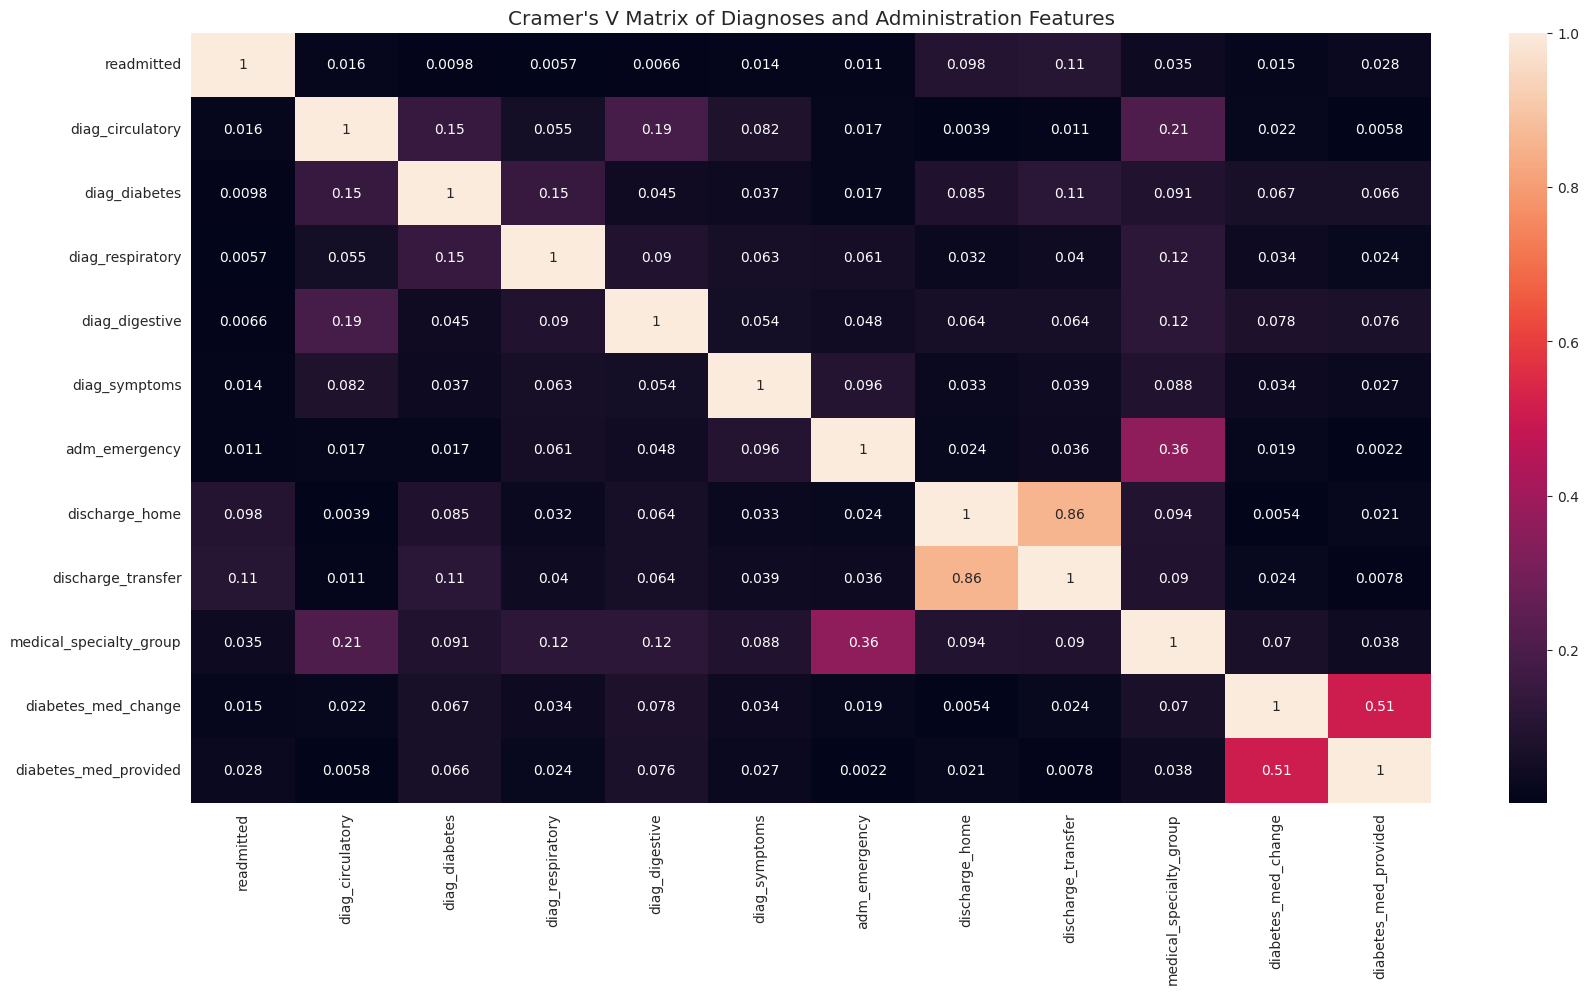

In [838]:
plt.figure(figsize=(20, 10))  # Set the figure size
cramer_matrix(
    data=diabetic_data,
    columns=[
        'readmitted',
        'diag_circulatory', 'diag_diabetes', 'diag_respiratory', 'diag_digestive', 'diag_symptoms',
        'adm_emergency', 'discharge_home', 'discharge_transfer', 'medical_specialty_group',
        'diabetes_med_change', 'diabetes_med_provided'
    ]
)
plt.title("Cramer's V Matrix of Diagnoses and Administration Features")
plt.show()

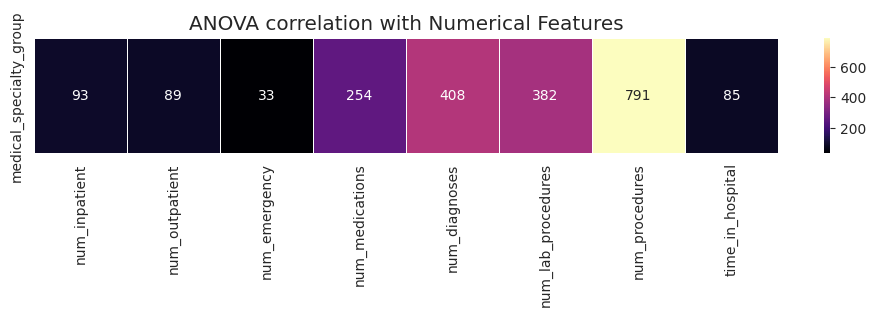

In [839]:
NUMERICAL_COLUMNS = [
    'num_inpatient', 'num_outpatient', 'num_emergency',
    'num_medications', 'num_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital'
]

plt.figure(figsize=(12, 1.5))  # Set the figure size
anova_matrix(
    data=diabetic_data,
    categorical_cols=['medical_specialty_group'],
    numerical_cols=NUMERICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'magma', fmt='.0f'
)
plt.title('ANOVA correlation with Numerical Features')
plt.show()

In [840]:
# Select the features and target
features = [
    'diag_circulatory', 'diag_diabetes', 'diag_respiratory', 'diag_digestive', 'diag_symptoms',
    'adm_emergency', 'num_medications', 'num_procedures', 'num_diagnoses'
]
target = 'medical_specialty_group'

# Set the missing values to None
diabetic_data.loc[diabetic_data[target] == 'Missing', target] = None

# Separate the data into training and prediction sets
train_data = diabetic_data[diabetic_data[target].notnull()]
predict_data = diabetic_data[diabetic_data[target].isnull()]

# Prepare the training data
X_train = train_data[features]
y_train = train_data[target]

# Prepare the prediction data
X_predict = predict_data[features]

# Train the model
model = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict the missing values
predictions = model.predict(X_predict)

In [841]:
# Impute the missing values in the original DataFrame
diabetic_data.loc[diabetic_data[target].isnull(), target] = predictions

In [842]:
specialty_counts = get_readmission_distribution('medical_specialty_group', 'Medical Specialty Group', sort_by='Total')
specialty_counts

Medical Specialty Group  No Readmission  Readmission  Total  \
0                Internal Medicine           38410         3852  42262   
1                            Other           10833         1156  11989   
2      Cardiology & Cardiovascular            7664          664   8328   
3           Acute & Emergency Care            4233          375   4608   
4                          Surgery            2643          257   2900   
5                    Mental Health             642           88    730   
6  Pulmonary $ Infectious Diseases             620           69    689   

   Percentage  
0    0.091146  
1    0.096422  
2    0.079731  
3    0.081380  
4    0.088621  
5    0.120548  
6    0.100145

In [843]:
diabetic_data['medical_internal'] = diabetic_data['medical_specialty_group'].apply(
    lambda disch: 1 if disch == "Internal Medicine" else 0
)

diabetic_data['medical_cardio'] = diabetic_data['medical_specialty_group'].apply(
    lambda disch: 1 if disch == "Cardiology & Cardiovascular" else 0
)

diabetic_data['medical_surgery'] = diabetic_data['medical_specialty_group'].apply(
    lambda disch: 1 if disch == "Surgery" else 0
)

### 3.3 Feature Extraction
Creating new features from existing ones.

#### 3.3.1 PCA

In [844]:
features = [
    'age',
    'num_inpatient', 'num_outpatient', 'num_emergency',
    'num_medications', 'num_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital',
]

# Select the features and target
X = diabetic_data.copy()
y = X.pop('readmitted')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [845]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.386378 -1.812021 -1.484790 -0.138950 -0.214064 -0.039969  0.001731   
1 -1.724133 -0.932804 -0.853062  0.834011 -0.296933 -0.595023 -1.131075   
2  1.550763 -0.267710  1.084296  0.101993 -0.176314  0.304992 -0.043143   
3  0.369697  0.192338  1.560103 -0.045041 -0.048315  0.452971  0.209441   
4 -2.020744 -0.938731 -1.381133  1.639802 -0.892024 -0.616984 -0.633048   

        PC8       PC9  
0 -0.877769  0.147360  
1 -0.357748  0.282407  
2 -1.037018  0.714142  
3 -0.139682  0.977374  
4  0.598654 -0.747331

In [846]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

PC1       PC2       PC3       PC4       PC5  \
age                 0.172612  0.173262  0.729088 -0.199083  0.254181   
num_inpatient       0.126908  0.488849 -0.173643  0.289861  0.622604   
num_outpatient      0.048662  0.482654 -0.125086 -0.495124 -0.525331   
num_emergency       0.042414  0.538652 -0.388601  0.017497  0.035189   
num_medications     0.549147 -0.140888 -0.180290 -0.146353  0.016695   
num_diagnoses       0.365433  0.251628  0.324180 -0.173917 -0.032911   
num_lab_procedures  0.369955  0.014468  0.000769  0.587321 -0.408332   
num_procedures      0.322567 -0.340579 -0.364707 -0.450349  0.308607   
time_in_hospital    0.523367 -0.092396  0.031820  0.177389 -0.084913   

                         PC6       PC7       PC8       PC9  
age                 0.010572 -0.513398 -0.192248  0.061042  
num_inpatient      -0.470959  0.145939  0.003569  0.000636  
num_outpatient     -0.464915 -0.083270 -0.002787 -0.069447  
num_emergency       0.670891 -0.322581 -0.030115 -0.020972  
num_medications    -0.010432 -0.042806  0.211089  0.760189  
num_diagnoses       0.318394  0.740648 -0.073387 -0.106771  
num_lab_procedures -0.094051 -0.083165 -0.579073  0.012478  
num_procedures     -0.024679 -0.062296 -0.471855 -0.348934  
time_in_hospital   -0.030105 -0.207228  0.595144 -0.528974

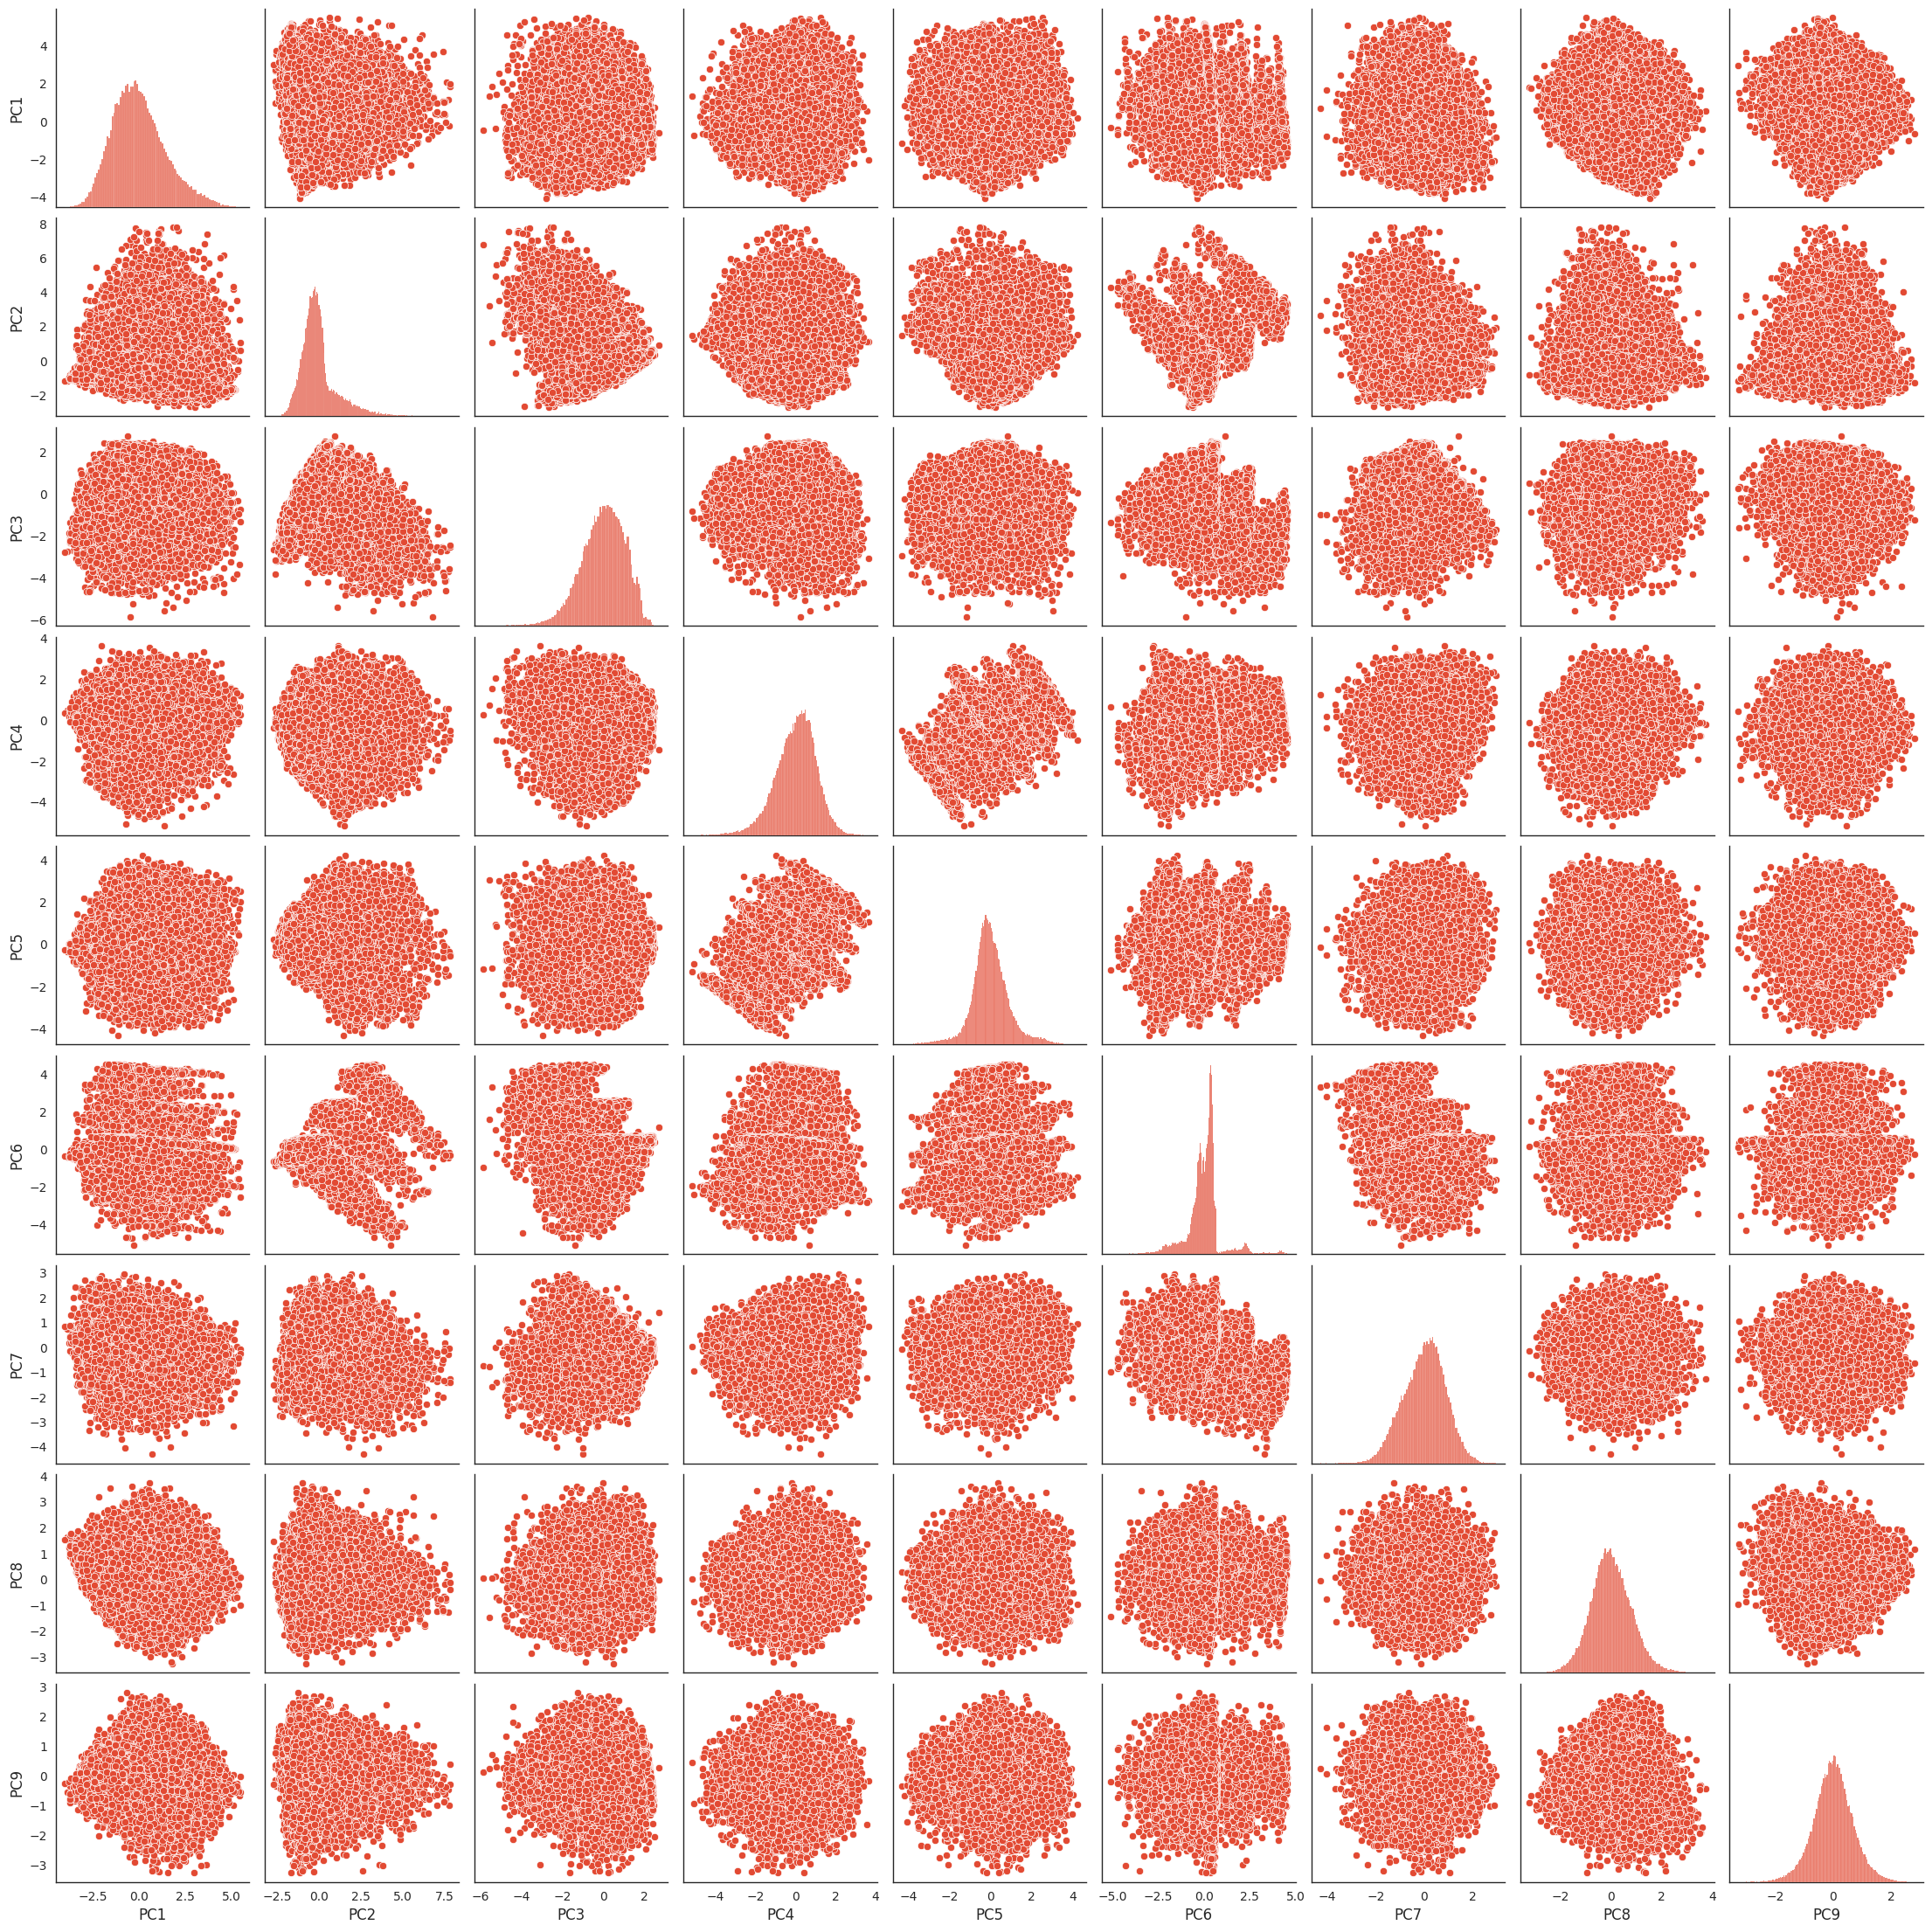

In [847]:
sns.pairplot(
    data=X_pca,
)

### 3.4 Data Post-Cleaning
Removing entries, based on discoveries made during the preprocessing phase.

#### 3.4.1 Dropping dangling features
Removing features that are not anymore needed.

In [848]:
diabetic_data = diabetic_data.drop(columns=[
    'patient_nbr', 'race',
    'diag_1', 'diag_2', 'diag_3', 'diag_1_group', 'diag_2_group', 'diag_3_group',
    'admission_type_id', 'admission_source_id', 'admission_source_group',
    'discharge_disposition_id', 'discharge_disposition_group',
    'medical_specialty', 'medical_specialty_group',
    'max_glu_serum', 'A1Cresult',
    'metformin', 'insulin',
    'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol',
    'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
])
diabetic_data.sample(5)

age  gender  time_in_hospital  num_lab_procedures  num_procedures  \
10282  7.0       1               2.0                  72               0   
20962  8.0       0               8.0                  90               0   
65273  8.0       1               3.0                  44               0   
543    5.0       1               8.0                  71               4   
61966  6.0       0               1.0                  44               0   

       num_medications  num_outpatient  num_emergency  num_inpatient  \
10282               11               0              0              0   
20962               15               0              0              0   
65273               15               1              0              0   
543                 24               0              0              0   
61966               13               0              0              0   

       num_diagnoses  diabetes_med_change  diabetes_med_provided  readmitted  \
10282              5                    0                      1           0   
20962              9                    1                      1           0   
65273              9                    1                      1           0   
543                9                    0                      1           0   
61966              9                    1                      1           0   

       discharge_home  discharge_transfer  diag_circulatory  diag_diabetes  \
10282               0                   1                 1              0   
20962               0                   1                 0              0   
65273               1                   0                 1              0   
543                 1                   0                 0              0   
61966               1                   0                 1              0   

       diag_respiratory  diag_digestive  diag_symptoms  adm_emergency  \
10282                 0               0              0              0   
20962                 0               0              0              1   
65273                 0               0              0              1   
543                   0               1              0              1   
61966                 0               0              0              1   

       insulin_given  insulin_dose_changed  metformin_given  medical_internal  \
10282              1                     0                0                 1   
20962              0                     0                1                 1   
65273              0                     0                0                 0   
543                0                     0                1                 1   
61966              1                     0                1                 1   

       medical_cardio  medical_surgery  
10282               0                0  
20962               0                0  
65273               0                0  
543                 0                0  
61966               0                0

#### 3.4.2 Duplicates
Looking for duplicate instances, by excluding the reference to the patient and encounter identifiers. Luckily, there are none of them.

In [849]:
duplicates = diabetic_data[diabetic_data.duplicated()]
duplicates

age  gender  time_in_hospital  num_lab_procedures  num_procedures  \
2392   1.0       0               2.0                  47               0   
3147   5.0       1               2.0                  34               0   
5770   2.0       1               3.0                  22               1   
12943  1.0       1               3.0                  51               0   
15171  3.0       1               3.0                  22               1   
22225  6.0       0               8.0                  50               6   
47974  4.0       1               8.0                  57               3   
50216  6.0       0               1.0                  56               1   
54364  7.0       1               1.0                  35               2   

       num_medications  num_outpatient  num_emergency  num_inpatient  \
2392                 3               0              0              0   
3147                 8               0              0              0   
5770                15               0              0              0   
12943                3               0              0              0   
15171               15               0              0              0   
22225               36               0              0              0   
47974               24               0              0              1   
50216               10               0              0              0   
54364               13               0              0              0   

       num_diagnoses  diabetes_med_change  diabetes_med_provided  readmitted  \
2392               7                    0                      1           0   
3147               4                    0                      1           0   
5770               7                    0                      0           0   
12943              7                    0                      1           0   
15171              7                    0                      0           0   
22225              9                    1                      1           0   
47974              9                    1                      1           0   
50216              9                    0                      1           0   
54364              8                    0                      0           0   

       discharge_home  discharge_transfer  diag_circulatory  diag_diabetes  \
2392                1                   0                 0              1   
3147                1                   0                 0              1   
5770                1                   0                 0              1   
12943               1                   0                 0              1   
15171               1                   0                 0              1   
22225               1                   0                 1              0   
47974               1                   0                 0              0   
50216               1                   0                 1              0   
54364               1                   0                 1              0   

       diag_respiratory  diag_digestive  diag_symptoms  adm_emergency  \
2392                  0               0              0              1   
3147                  0               0              1              1   
5770                  0               0              0              0   
12943                 0               0              0              1   
15171                 0               0              0              0   
22225                 0               0              0              0   
47974                 0               1              0              1   
50216                 0               0              0              1   
54364                 0               0              0              0   

       insulin_given  insulin_dose_changed  metformin_given  medical_internal  \
2392               1                     0                0                 0   
3147               0                     0        

In [850]:
diabetic_data.drop_duplicates(inplace=True)
diabetic_data.reset_index(drop=True, inplace=True)

## **4. Data Visualization (after)**
Having a more thourough look at the relationships between features, after preprocessing.

### 4.1 Correlation / Association
Exploring the numeric correlation or association between different features.

In [851]:
NUMERICAL_COLUMNS = [
    'age',
    'num_inpatient', 'num_outpatient', 'num_emergency',
    'num_medications', 'num_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital',
]

BINARY_COLUMNS = [
    'readmitted', 'gender',
    'diag_circulatory', 'diag_diabetes', 'diag_respiratory', 'diag_digestive', 'diag_symptoms',
    'adm_emergency', 'discharge_home', 'discharge_transfer',
    'medical_internal', 'medical_cardio', 'medical_surgery',
    'insulin_given', 'insulin_dose_changed', 'metformin_given',
    'diabetes_med_change', 'diabetes_med_provided',
]

In [852]:
df = diabetic_data.sample(frac=1, random_state=RANDOM_STATE)

readmitted = df[df['readmitted'] == 1]
non_readmitted = df[df['readmitted'] == 0].sample(n=len(readmitted), random_state=RANDOM_STATE)

sub_sample_df = pd.concat([readmitted, non_readmitted], axis=0).sample(frac=1, random_state=RANDOM_STATE)

#### 4.1.1 Numerical features
Above, the only numerical relation that exists with readmissions is related to the number of inpatient visits. Other features present very little or absent correlation with readmission status.

Below, correlation of numerical features with readmitted (binary), by using Point Biserial correlation.

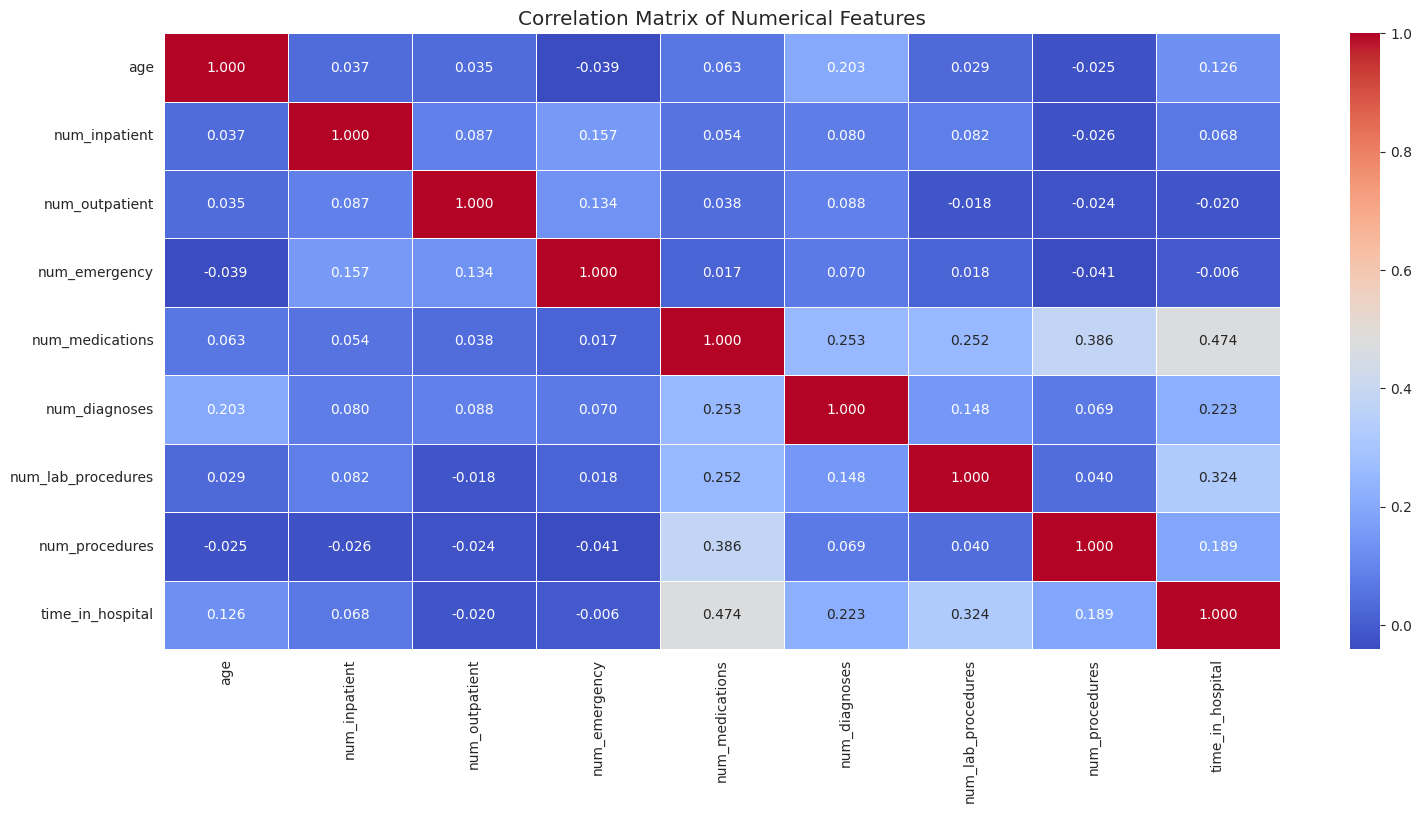

In [853]:
temp_data = diabetic_data[NUMERICAL_COLUMNS]
data_corr = temp_data.corr()

plt.figure(figsize=(18, 8))  # Set the figure size
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.3f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

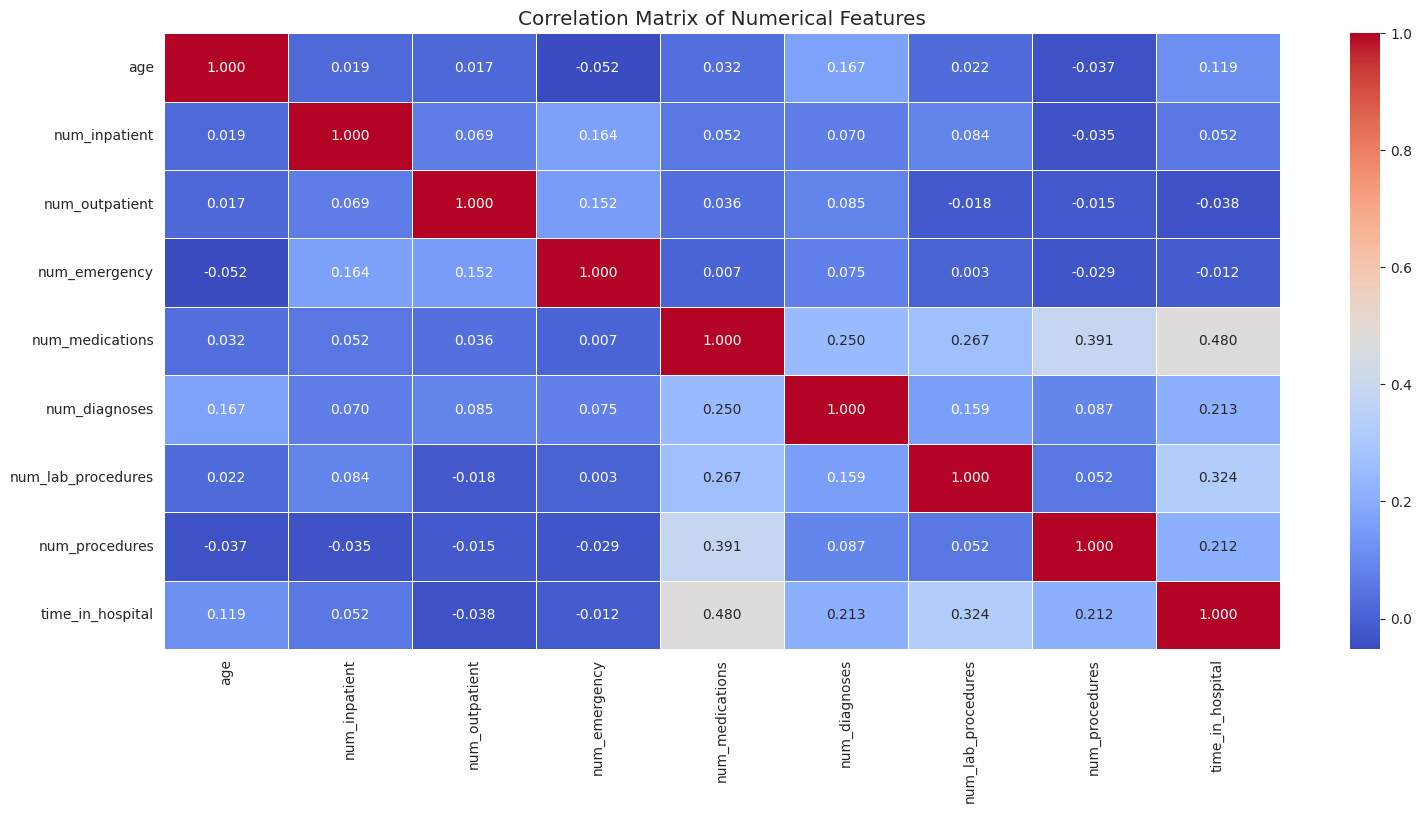

In [854]:
temp_data = sub_sample_df[NUMERICAL_COLUMNS]
data_corr = temp_data.corr()

plt.figure(figsize=(18, 8))  # Set the figure size
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.3f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### 4.1.2 Binary-numerical features

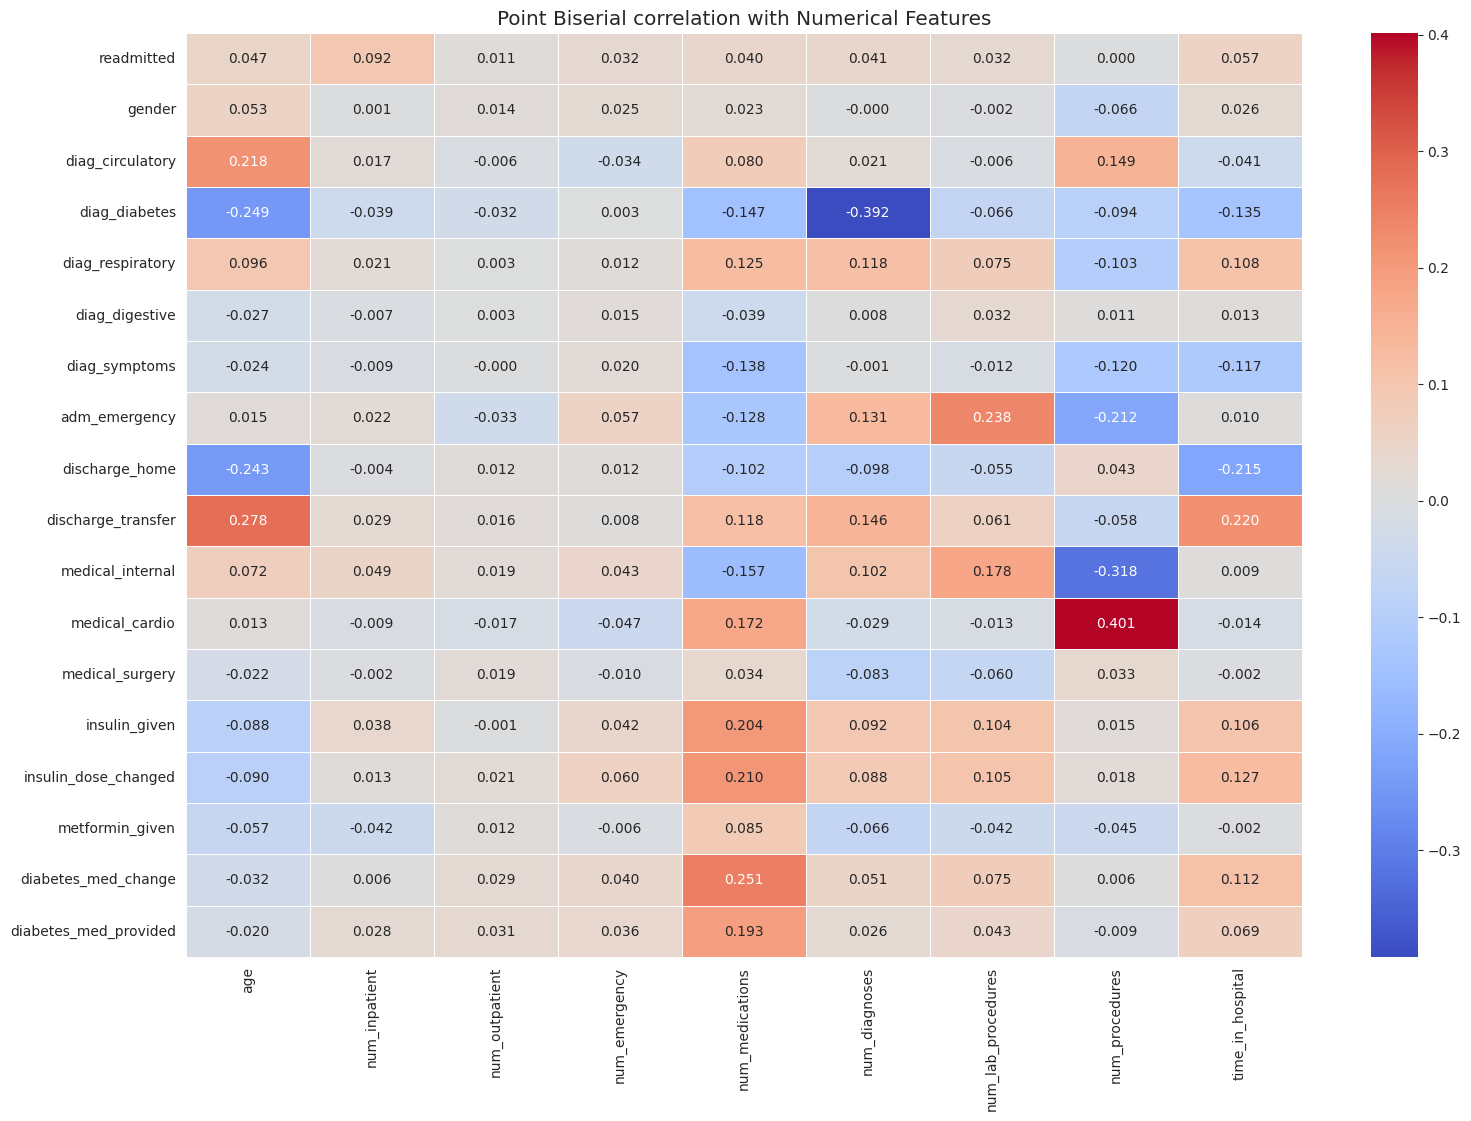

In [855]:
plt.figure(figsize=(18, 12))  # Set the figure size
point_biserial_matrix(
    data=diabetic_data,
    binary_cols=BINARY_COLUMNS,
    numerical_cols=NUMERICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'coolwarm', fmt='.3f'
)
plt.title('Point Biserial correlation with Numerical Features')
plt.show()

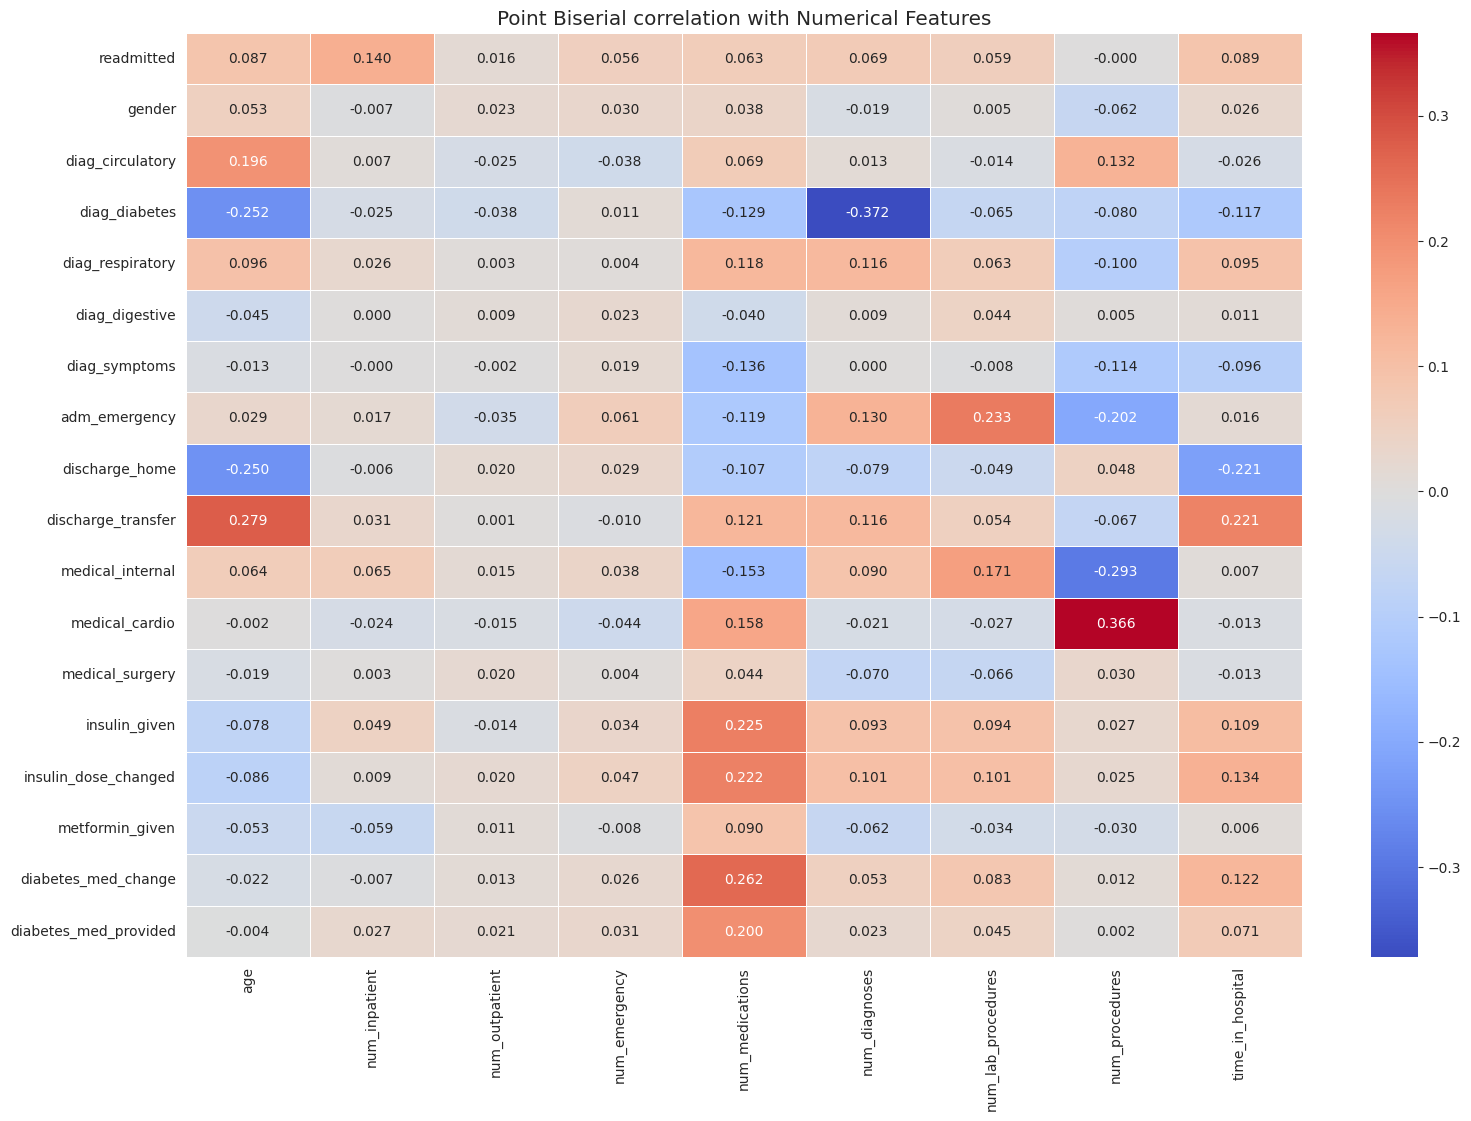

In [856]:
plt.figure(figsize=(18, 12))  # Set the figure size
point_biserial_matrix(
    data=sub_sample_df,
    binary_cols=BINARY_COLUMNS,
    numerical_cols=NUMERICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'coolwarm', fmt='.3f'
)
plt.title('Point Biserial correlation with Numerical Features')
plt.show()

#### 4.1.3 Binary features

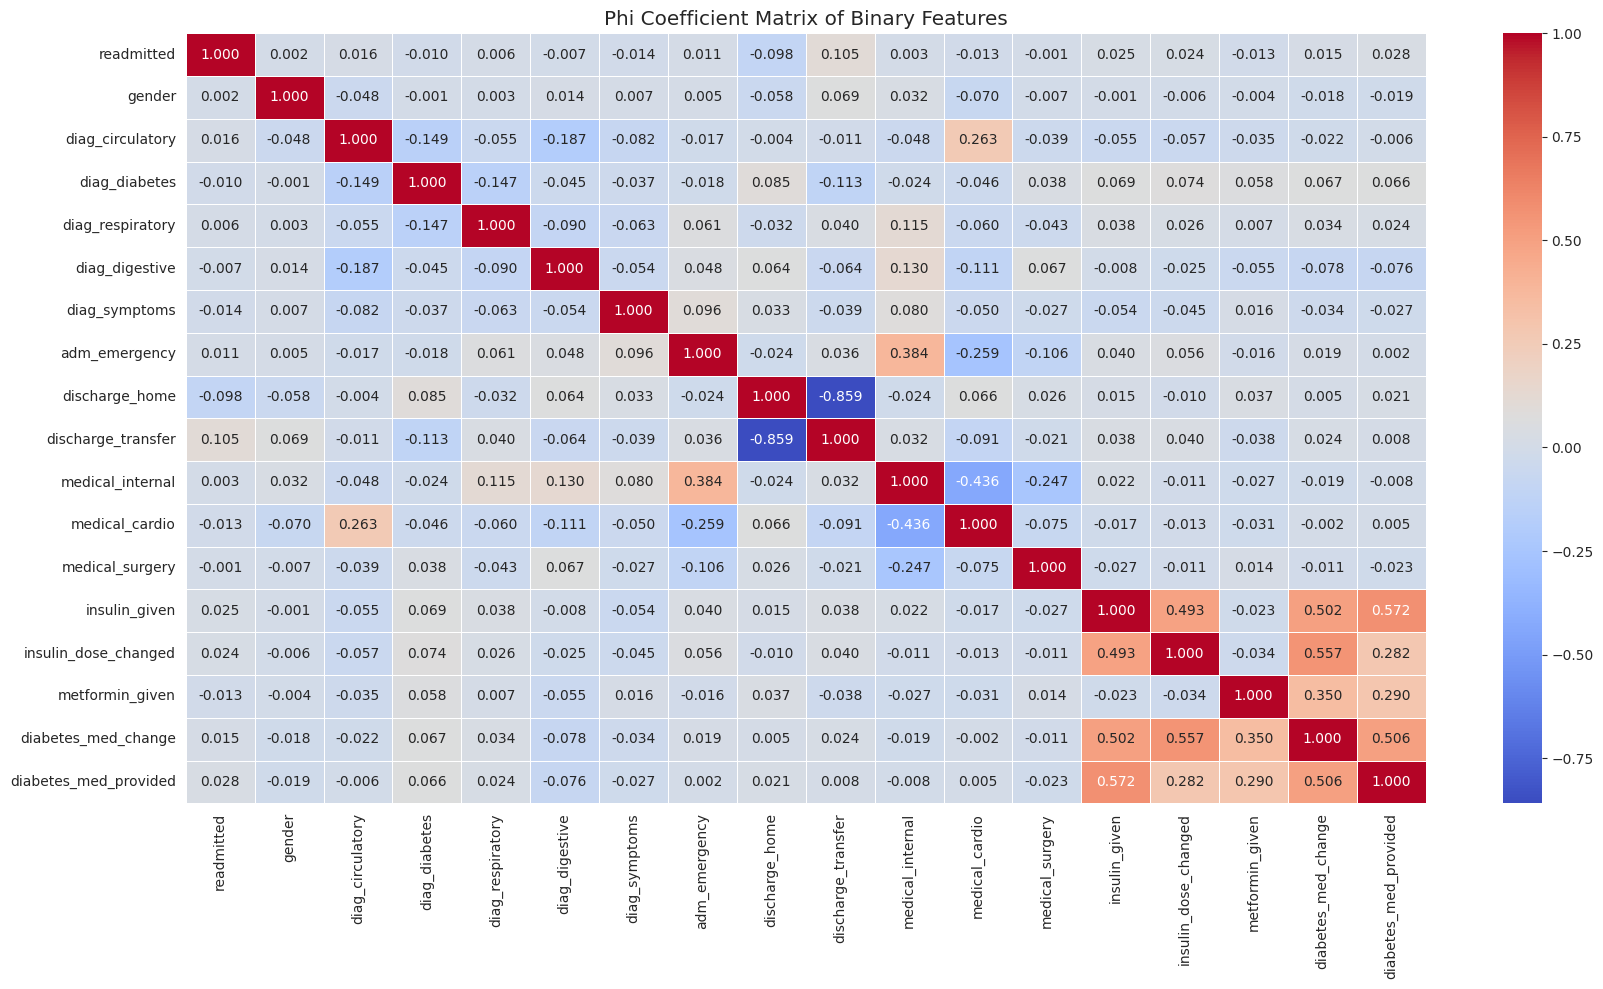

In [857]:
plt.figure(figsize=(20, 10))  # Set the figure size
phi_matrix(
    data=diabetic_data,
    binary_cols=BINARY_COLUMNS,
    linewidths=0.5,
    cmap = 'coolwarm', fmt='.3f'
)
plt.title("Phi Coefficient Matrix of Binary Features")
plt.show()

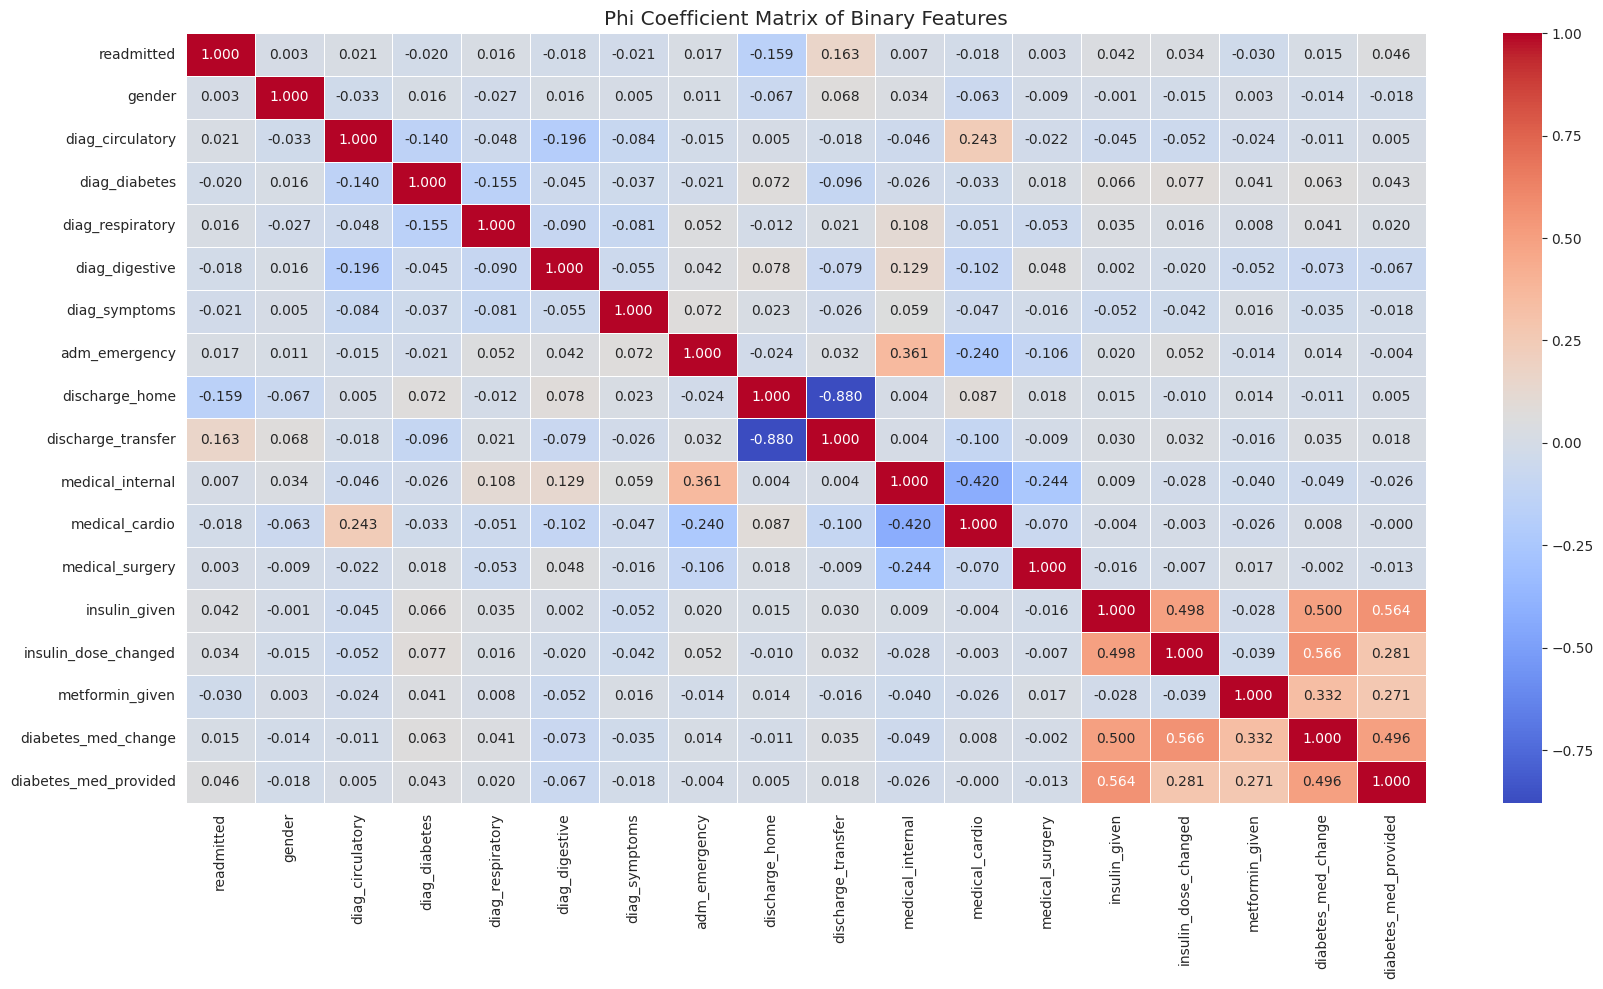

In [858]:
plt.figure(figsize=(20, 10))  # Set the figure size
phi_matrix(
    data=sub_sample_df,
    binary_cols=BINARY_COLUMNS,
    linewidths=0.5,
    cmap = 'coolwarm', fmt='.3f'
)
plt.title("Phi Coefficient Matrix of Binary Features")
plt.show()

## **5. Saving preprocessed dataset**

In [859]:
diabetic_data.sample(5)

age  gender  time_in_hospital  num_lab_procedures  num_procedures  \
3948   6.0       1               7.0                  29               6   
34054  3.0       1               7.0                  26               1   
61222  6.0       1               5.0                  44               2   
31524  6.0       1               1.0                  15               2   
47316  8.0       1               6.0                  68               0   

       num_medications  num_outpatient  num_emergency  num_inpatient  \
3948                14               0              0              0   
34054               27               0              0              0   
61222               15               1              1              0   
31524               26               0              0              0   
47316               10               0              0              0   

       num_diagnoses  diabetes_med_change  diabetes_med_provided  readmitted  \
3948               9                    0                      1           0   
34054              9                    1                      1           0   
61222              4                    1                      1           0   
31524              5                    1                      1           0   
47316              6                    0                      1           1   

       discharge_home  discharge_transfer  diag_circulatory  diag_diabetes  \
3948                1                   0                 1              0   
34054               1                   0                 0              0   
61222               1                   0                 0              1   
31524               1                   0                 1              0   
47316               0                   1                 0              0   

       diag_respiratory  diag_digestive  diag_symptoms  adm_emergency  \
3948                  0               1              0              0   
34054                 0               1              0              0   
61222                 0               1              0              1   
31524                 0               0              0              0   
47316                 0               0              0              1   

       insulin_given  insulin_dose_changed  metformin_given  medical_internal  \
3948               1                     0                0                 1   
34054              1                     1                1                 1   
61222              1                     0                1                 1   
31524              1                     0                0                 0   
47316              1                     0                0                 1   

       medical_cardio  medical_surgery  
3948                0                0  
34054               0                0  
61222               0                0  
31524               0                0  
47316               0                0

In [1181]:
# TODO: Save the cleaned data
diabetic_data.to_csv(
    DATA_PATH_PROCESSED + 'diabetic_data_cleaned.csv',
    index=False
)